In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    ################################################ s', r = env(s, a)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    next_states_logits, Qlogits = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                      action_size=action_size, state_size=state_size)
    eloss = tf.reduce_mean(tf.reduce_sum(tf.square(next_states - next_states_logits), axis=1))
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, nextQlogits = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                          action_size=action_size, state_size=state_size, reuse=True)
    #################################################### GAN
    Qlogits = tf.reshape(Qlogits, shape=[-1])
    nextQlogits = tf.reshape(nextQlogits, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qlogits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQlogits, # GAN
                                                                    labels=tf.zeros_like(rates)))
    aloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQlogits, # GAN
                                                                   labels=tf.ones_like(rates)))
    #     #########################################################
    #     eloss += tf.reduce_mean(nextQlogits) # minimize nextQ
    #     aloss = -tf.reduce_mean(nextQlogits) # maximize nextQ
    ###################################################### Qlearning
    ###################################################### Q(s,a)= r + Q'(s',a')
    rewards = Qlogits - (gamma * nextQlogits)
    Qent = tf.reduce_mean(tf.square(rewards))
    ##################################################### GAN + DDPG
    eloss += tf.reduce_mean(Qent) # minimize entropy: error
    aloss += -tf.reduce_mean(Qent) # maximize entropy: rewards
    return actions_logits, aloss, eloss, rewards

In [7]:
def model_opt(a_loss, e_loss, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
    return a_opt, e_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.rewards_ = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt = model_opt(a_loss=self.a_loss, e_loss=self.e_loss,
                                           a_learning_rate=a_learning_rate,
                                           e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
def minibacth_random(memory, batch_size):
    # Training with the maxrated minibatch
    while True:
        batch = memory.sample(batch_size=batch_size)
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        next_states = np.array([each[2] for each in batch])
        rewards = np.array([each[3] for each in batch])
        dones = np.array([each[4] for each in batch])
        rates = np.array([each[5] for each in batch])
        states = states[rates > 0]
        actions = actions[rates > 0]
        next_states = next_states[rates > 0]
        rewards = rewards[rates > 0]
        dones = dones[rates > 0]
        rates = rates[rates > 0]
        if len(dones) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [16]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss_batch.append(eloss)
            aloss_batch.append(aloss)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 aloss:0.7285 eloss:2.3935 exploreP:0.9983
Episode:1 meanR:35.5000 R:54.0000 rate:0.1080 aloss:0.7239 eloss:2.3025 exploreP:0.9930
Episode:2 meanR:28.6667 R:15.0000 rate:0.0300 aloss:0.7165 eloss:2.1948 exploreP:0.9915
Episode:3 meanR:28.7500 R:29.0000 rate:0.0580 aloss:0.7229 eloss:2.2275 exploreP:0.9887
Episode:4 meanR:26.2000 R:16.0000 rate:0.0320 aloss:0.7094 eloss:2.2372 exploreP:0.9871
Episode:5 meanR:24.1667 R:14.0000 rate:0.0280 aloss:0.7191 eloss:2.4776 exploreP:0.9857
Episode:6 meanR:22.7143 R:14.0000 rate:0.0280 aloss:0.7189 eloss:2.3574 exploreP:0.9844
Episode:7 meanR:22.0000 R:17.0000 rate:0.0340 aloss:0.7128 eloss:2.3143 exploreP:0.9827
Episode:8 meanR:21.1111 R:14.0000 rate:0.0280 aloss:0.7201 eloss:2.8523 exploreP:0.9814
Episode:9 meanR:20.5000 R:15.0000 rate:0.0300 aloss:0.7217 eloss:3.1492 exploreP:0.9799
Episode:10 meanR:20.6364 R:22.0000 rate:0.0440 aloss:0.7130 eloss:2.4329 exploreP:0.9778
Episode:11 meanR:21.8333 R:35.0

Episode:93 meanR:20.1702 R:12.0000 rate:0.0240 aloss:0.6950 eloss:2.3933 exploreP:0.8290
Episode:94 meanR:20.4000 R:42.0000 rate:0.0840 aloss:0.6947 eloss:2.3182 exploreP:0.8256
Episode:95 meanR:20.4479 R:25.0000 rate:0.0500 aloss:0.6938 eloss:2.3057 exploreP:0.8235
Episode:96 meanR:20.3402 R:10.0000 rate:0.0200 aloss:0.6987 eloss:2.0740 exploreP:0.8227
Episode:97 meanR:20.2857 R:15.0000 rate:0.0300 aloss:0.6948 eloss:1.9242 exploreP:0.8215
Episode:98 meanR:20.3030 R:22.0000 rate:0.0440 aloss:0.6979 eloss:2.3445 exploreP:0.8197
Episode:99 meanR:20.3300 R:23.0000 rate:0.0460 aloss:0.7001 eloss:2.1843 exploreP:0.8179
Episode:100 meanR:20.2900 R:13.0000 rate:0.0260 aloss:0.7013 eloss:2.0895 exploreP:0.8168
Episode:101 meanR:19.8700 R:12.0000 rate:0.0240 aloss:0.7069 eloss:2.2083 exploreP:0.8159
Episode:102 meanR:19.8300 R:11.0000 rate:0.0220 aloss:0.6992 eloss:2.1466 exploreP:0.8150
Episode:103 meanR:19.7700 R:23.0000 rate:0.0460 aloss:0.7054 eloss:2.1870 exploreP:0.8131
Episode:104 meanR

Episode:185 meanR:17.8200 R:14.0000 rate:0.0280 aloss:0.9140 eloss:1.7016 exploreP:0.7046
Episode:186 meanR:17.8700 R:25.0000 rate:0.0500 aloss:0.9147 eloss:1.7182 exploreP:0.7028
Episode:187 meanR:17.7800 R:12.0000 rate:0.0240 aloss:0.9141 eloss:1.7230 exploreP:0.7020
Episode:188 meanR:17.7500 R:12.0000 rate:0.0240 aloss:0.8961 eloss:2.0593 exploreP:0.7012
Episode:189 meanR:17.8100 R:24.0000 rate:0.0480 aloss:0.9161 eloss:1.8318 exploreP:0.6995
Episode:190 meanR:17.9000 R:22.0000 rate:0.0440 aloss:0.9244 eloss:1.8759 exploreP:0.6980
Episode:191 meanR:18.0800 R:26.0000 rate:0.0520 aloss:0.9130 eloss:1.7600 exploreP:0.6962
Episode:192 meanR:18.0700 R:26.0000 rate:0.0520 aloss:0.9140 eloss:1.8255 exploreP:0.6944
Episode:193 meanR:18.1200 R:17.0000 rate:0.0340 aloss:0.9155 eloss:1.7515 exploreP:0.6933
Episode:194 meanR:18.0100 R:31.0000 rate:0.0620 aloss:0.9196 eloss:1.8496 exploreP:0.6912
Episode:195 meanR:17.8700 R:11.0000 rate:0.0220 aloss:0.9146 eloss:2.0852 exploreP:0.6904
Episode:19

Episode:277 meanR:15.5300 R:16.0000 rate:0.0320 aloss:0.9405 eloss:1.8071 exploreP:0.6120
Episode:278 meanR:15.5300 R:14.0000 rate:0.0280 aloss:0.9478 eloss:1.8843 exploreP:0.6112
Episode:279 meanR:15.4900 R:15.0000 rate:0.0300 aloss:0.9358 eloss:1.7976 exploreP:0.6103
Episode:280 meanR:15.4700 R:10.0000 rate:0.0200 aloss:0.9388 eloss:1.6707 exploreP:0.6097
Episode:281 meanR:15.8600 R:53.0000 rate:0.1060 aloss:0.9451 eloss:1.7951 exploreP:0.6065
Episode:282 meanR:15.8300 R:10.0000 rate:0.0200 aloss:0.9440 eloss:1.8016 exploreP:0.6059
Episode:283 meanR:15.7600 R:13.0000 rate:0.0260 aloss:0.9543 eloss:1.8161 exploreP:0.6051
Episode:284 meanR:15.7500 R:16.0000 rate:0.0320 aloss:0.9527 eloss:1.7274 exploreP:0.6042
Episode:285 meanR:15.7100 R:10.0000 rate:0.0200 aloss:0.9398 eloss:1.6465 exploreP:0.6036
Episode:286 meanR:15.5800 R:12.0000 rate:0.0240 aloss:0.9383 eloss:1.8339 exploreP:0.6029
Episode:287 meanR:15.6200 R:16.0000 rate:0.0320 aloss:0.9666 eloss:1.9123 exploreP:0.6019
Episode:28

Episode:369 meanR:14.8600 R:9.0000 rate:0.0180 aloss:1.0242 eloss:1.7290 exploreP:0.5354
Episode:370 meanR:14.8600 R:10.0000 rate:0.0200 aloss:1.0231 eloss:1.7101 exploreP:0.5349
Episode:371 meanR:14.8700 R:24.0000 rate:0.0480 aloss:1.0165 eloss:1.7629 exploreP:0.5336
Episode:372 meanR:14.9000 R:13.0000 rate:0.0260 aloss:1.0355 eloss:1.6075 exploreP:0.5330
Episode:373 meanR:14.8300 R:11.0000 rate:0.0220 aloss:1.0362 eloss:1.4790 exploreP:0.5324
Episode:374 meanR:14.8400 R:15.0000 rate:0.0300 aloss:1.0207 eloss:1.7387 exploreP:0.5316
Episode:375 meanR:14.8100 R:11.0000 rate:0.0220 aloss:1.0253 eloss:1.6213 exploreP:0.5310
Episode:376 meanR:14.7300 R:12.0000 rate:0.0240 aloss:0.9810 eloss:2.1671 exploreP:0.5304
Episode:377 meanR:14.6900 R:12.0000 rate:0.0240 aloss:1.0098 eloss:1.6446 exploreP:0.5298
Episode:378 meanR:14.7100 R:16.0000 rate:0.0320 aloss:1.0270 eloss:1.6628 exploreP:0.5289
Episode:379 meanR:14.6900 R:13.0000 rate:0.0260 aloss:1.0235 eloss:1.7703 exploreP:0.5283
Episode:380

Episode:461 meanR:13.8300 R:10.0000 rate:0.0200 aloss:1.0411 eloss:1.6508 exploreP:0.4724
Episode:462 meanR:13.8000 R:10.0000 rate:0.0200 aloss:1.0409 eloss:1.3910 exploreP:0.4720
Episode:463 meanR:13.8100 R:13.0000 rate:0.0260 aloss:1.0406 eloss:1.4422 exploreP:0.4714
Episode:464 meanR:13.7100 R:9.0000 rate:0.0180 aloss:1.0383 eloss:1.5606 exploreP:0.4710
Episode:465 meanR:13.7400 R:14.0000 rate:0.0280 aloss:1.0369 eloss:1.5100 exploreP:0.4703
Episode:466 meanR:13.8200 R:19.0000 rate:0.0380 aloss:1.0434 eloss:1.5866 exploreP:0.4694
Episode:467 meanR:13.8300 R:16.0000 rate:0.0320 aloss:1.0436 eloss:1.5477 exploreP:0.4687
Episode:468 meanR:13.8700 R:20.0000 rate:0.0400 aloss:1.0401 eloss:1.4881 exploreP:0.4678
Episode:469 meanR:13.9200 R:14.0000 rate:0.0280 aloss:1.0383 eloss:1.6027 exploreP:0.4671
Episode:470 meanR:13.9900 R:17.0000 rate:0.0340 aloss:1.0343 eloss:1.5641 exploreP:0.4664
Episode:471 meanR:13.9500 R:20.0000 rate:0.0400 aloss:1.0418 eloss:1.6389 exploreP:0.4655
Episode:472

Episode:553 meanR:13.2200 R:11.0000 rate:0.0220 aloss:1.0618 eloss:1.4196 exploreP:0.4188
Episode:554 meanR:13.2200 R:11.0000 rate:0.0220 aloss:1.0617 eloss:1.4475 exploreP:0.4183
Episode:555 meanR:13.2300 R:14.0000 rate:0.0280 aloss:1.0578 eloss:1.3556 exploreP:0.4178
Episode:556 meanR:13.2400 R:13.0000 rate:0.0260 aloss:1.0637 eloss:1.3431 exploreP:0.4172
Episode:557 meanR:13.2300 R:10.0000 rate:0.0200 aloss:1.0589 eloss:1.4023 exploreP:0.4168
Episode:558 meanR:13.2400 R:12.0000 rate:0.0240 aloss:1.0549 eloss:1.3325 exploreP:0.4163
Episode:559 meanR:13.2400 R:11.0000 rate:0.0220 aloss:1.0670 eloss:1.4233 exploreP:0.4159
Episode:560 meanR:13.2500 R:11.0000 rate:0.0220 aloss:1.0758 eloss:1.3383 exploreP:0.4155
Episode:561 meanR:13.2600 R:11.0000 rate:0.0220 aloss:1.0609 eloss:1.5716 exploreP:0.4150
Episode:562 meanR:13.2700 R:11.0000 rate:0.0220 aloss:1.0654 eloss:1.3469 exploreP:0.4146
Episode:563 meanR:13.2500 R:11.0000 rate:0.0220 aloss:1.0670 eloss:1.3120 exploreP:0.4141
Episode:56

Episode:645 meanR:12.8100 R:9.0000 rate:0.0180 aloss:1.0764 eloss:1.5346 exploreP:0.3731
Episode:646 meanR:12.8300 R:14.0000 rate:0.0280 aloss:1.0928 eloss:1.2850 exploreP:0.3726
Episode:647 meanR:12.7700 R:9.0000 rate:0.0180 aloss:1.0623 eloss:1.2937 exploreP:0.3723
Episode:648 meanR:12.7600 R:9.0000 rate:0.0180 aloss:1.0918 eloss:1.3680 exploreP:0.3720
Episode:649 meanR:12.7200 R:11.0000 rate:0.0220 aloss:1.0984 eloss:1.3040 exploreP:0.3716
Episode:650 meanR:12.6800 R:9.0000 rate:0.0180 aloss:1.0774 eloss:1.3641 exploreP:0.3713
Episode:651 meanR:12.6700 R:10.0000 rate:0.0200 aloss:1.0982 eloss:1.3115 exploreP:0.3709
Episode:652 meanR:12.6800 R:11.0000 rate:0.0220 aloss:1.0948 eloss:1.2957 exploreP:0.3705
Episode:653 meanR:12.7000 R:13.0000 rate:0.0260 aloss:1.0961 eloss:1.3003 exploreP:0.3700
Episode:654 meanR:12.6900 R:10.0000 rate:0.0200 aloss:1.0955 eloss:1.3584 exploreP:0.3697
Episode:655 meanR:12.6600 R:11.0000 rate:0.0220 aloss:1.0860 eloss:1.5119 exploreP:0.3693
Episode:656 me

Episode:737 meanR:12.2100 R:13.0000 rate:0.0260 aloss:1.1057 eloss:1.3050 exploreP:0.3354
Episode:738 meanR:12.1100 R:10.0000 rate:0.0200 aloss:1.1174 eloss:1.3053 exploreP:0.3351
Episode:739 meanR:12.0500 R:11.0000 rate:0.0220 aloss:1.1108 eloss:1.2138 exploreP:0.3347
Episode:740 meanR:12.0500 R:12.0000 rate:0.0240 aloss:1.1275 eloss:1.2015 exploreP:0.3343
Episode:741 meanR:12.0500 R:11.0000 rate:0.0220 aloss:1.1205 eloss:1.1971 exploreP:0.3340
Episode:742 meanR:12.0700 R:12.0000 rate:0.0240 aloss:1.0927 eloss:1.3318 exploreP:0.3336
Episode:743 meanR:12.0800 R:13.0000 rate:0.0260 aloss:1.0929 eloss:1.5304 exploreP:0.3331
Episode:744 meanR:11.8600 R:10.0000 rate:0.0200 aloss:1.1093 eloss:1.2377 exploreP:0.3328
Episode:745 meanR:11.8600 R:9.0000 rate:0.0180 aloss:1.1167 eloss:1.2214 exploreP:0.3325
Episode:746 meanR:11.8200 R:10.0000 rate:0.0200 aloss:1.1125 eloss:1.2834 exploreP:0.3322
Episode:747 meanR:11.8600 R:13.0000 rate:0.0260 aloss:1.1159 eloss:1.1891 exploreP:0.3318
Episode:748

Episode:829 meanR:11.0600 R:9.0000 rate:0.0180 aloss:1.1706 eloss:1.0809 exploreP:0.3040
Episode:830 meanR:11.0700 R:10.0000 rate:0.0200 aloss:1.1689 eloss:1.1432 exploreP:0.3037
Episode:831 meanR:11.0400 R:8.0000 rate:0.0160 aloss:1.1141 eloss:1.2588 exploreP:0.3035
Episode:832 meanR:11.0000 R:8.0000 rate:0.0160 aloss:0.9596 eloss:1.5469 exploreP:0.3033
Episode:833 meanR:11.0400 R:14.0000 rate:0.0280 aloss:1.1579 eloss:1.2005 exploreP:0.3029
Episode:834 meanR:11.0400 R:12.0000 rate:0.0240 aloss:1.1530 eloss:1.2973 exploreP:0.3025
Episode:835 meanR:11.0100 R:12.0000 rate:0.0240 aloss:1.1668 eloss:1.1233 exploreP:0.3022
Episode:836 meanR:11.1200 R:22.0000 rate:0.0440 aloss:1.1641 eloss:1.1232 exploreP:0.3015
Episode:837 meanR:11.1100 R:12.0000 rate:0.0240 aloss:1.1740 eloss:1.1108 exploreP:0.3012
Episode:838 meanR:11.1500 R:14.0000 rate:0.0280 aloss:1.1700 eloss:1.1072 exploreP:0.3008
Episode:839 meanR:11.1400 R:10.0000 rate:0.0200 aloss:1.1622 eloss:1.1816 exploreP:0.3005
Episode:840 m

Episode:921 meanR:10.9900 R:11.0000 rate:0.0220 aloss:1.2275 eloss:0.9868 exploreP:0.2754
Episode:922 meanR:11.0500 R:15.0000 rate:0.0300 aloss:1.2389 eloss:0.9518 exploreP:0.2750
Episode:923 meanR:11.1000 R:13.0000 rate:0.0260 aloss:1.2402 eloss:1.0367 exploreP:0.2747
Episode:924 meanR:11.1600 R:15.0000 rate:0.0300 aloss:1.2503 eloss:0.9443 exploreP:0.2743
Episode:925 meanR:11.1700 R:10.0000 rate:0.0200 aloss:1.2479 eloss:0.9942 exploreP:0.2740
Episode:926 meanR:11.1700 R:11.0000 rate:0.0220 aloss:1.2422 eloss:1.0372 exploreP:0.2737
Episode:927 meanR:11.1700 R:11.0000 rate:0.0220 aloss:1.2288 eloss:1.0413 exploreP:0.2734
Episode:928 meanR:11.2100 R:13.0000 rate:0.0260 aloss:1.2493 eloss:1.0294 exploreP:0.2731
Episode:929 meanR:11.2300 R:11.0000 rate:0.0220 aloss:1.2462 eloss:1.0194 exploreP:0.2728
Episode:930 meanR:11.2200 R:9.0000 rate:0.0180 aloss:1.2124 eloss:1.0490 exploreP:0.2726
Episode:931 meanR:11.2400 R:10.0000 rate:0.0200 aloss:1.2469 eloss:0.9943 exploreP:0.2723
Episode:932

Episode:1013 meanR:10.9200 R:13.0000 rate:0.0260 aloss:1.3005 eloss:1.0590 exploreP:0.2500
Episode:1014 meanR:10.9400 R:12.0000 rate:0.0240 aloss:1.3133 eloss:0.9017 exploreP:0.2497
Episode:1015 meanR:10.9200 R:10.0000 rate:0.0200 aloss:1.3151 eloss:1.1483 exploreP:0.2495
Episode:1016 meanR:10.9400 R:12.0000 rate:0.0240 aloss:1.3207 eloss:0.9023 exploreP:0.2492
Episode:1017 meanR:10.9600 R:12.0000 rate:0.0240 aloss:1.3432 eloss:0.9188 exploreP:0.2489
Episode:1018 meanR:10.9600 R:10.0000 rate:0.0200 aloss:1.3496 eloss:0.9503 exploreP:0.2487
Episode:1019 meanR:10.9500 R:11.0000 rate:0.0220 aloss:1.3254 eloss:0.9377 exploreP:0.2484
Episode:1020 meanR:10.9300 R:9.0000 rate:0.0180 aloss:1.3250 eloss:0.9462 exploreP:0.2482
Episode:1021 meanR:10.9200 R:10.0000 rate:0.0200 aloss:1.3182 eloss:0.9118 exploreP:0.2480
Episode:1022 meanR:10.8800 R:11.0000 rate:0.0220 aloss:1.3307 eloss:0.9417 exploreP:0.2477
Episode:1023 meanR:10.8600 R:11.0000 rate:0.0220 aloss:1.3324 eloss:0.8957 exploreP:0.2474


Episode:1104 meanR:10.9700 R:13.0000 rate:0.0260 aloss:1.4241 eloss:0.8582 exploreP:0.2274
Episode:1105 meanR:10.9600 R:10.0000 rate:0.0200 aloss:1.4102 eloss:0.8744 exploreP:0.2272
Episode:1106 meanR:10.8700 R:8.0000 rate:0.0160 aloss:1.4291 eloss:0.8658 exploreP:0.2270
Episode:1107 meanR:10.8600 R:8.0000 rate:0.0160 aloss:1.4034 eloss:0.8904 exploreP:0.2268
Episode:1108 meanR:10.8500 R:11.0000 rate:0.0220 aloss:1.4375 eloss:0.8353 exploreP:0.2266
Episode:1109 meanR:10.8300 R:9.0000 rate:0.0180 aloss:1.4003 eloss:0.8723 exploreP:0.2264
Episode:1110 meanR:10.8200 R:10.0000 rate:0.0200 aloss:1.4192 eloss:0.8195 exploreP:0.2262
Episode:1111 meanR:10.7900 R:9.0000 rate:0.0180 aloss:1.4061 eloss:0.8523 exploreP:0.2260
Episode:1112 meanR:10.8000 R:11.0000 rate:0.0220 aloss:1.4025 eloss:0.9150 exploreP:0.2257
Episode:1113 meanR:10.7800 R:11.0000 rate:0.0220 aloss:1.4192 eloss:0.8319 exploreP:0.2255
Episode:1114 meanR:10.8200 R:16.0000 rate:0.0320 aloss:1.4401 eloss:0.8543 exploreP:0.2251
Epi

Episode:1195 meanR:10.4900 R:10.0000 rate:0.0200 aloss:1.5107 eloss:0.8660 exploreP:0.2077
Episode:1196 meanR:10.5100 R:12.0000 rate:0.0240 aloss:1.4981 eloss:0.8537 exploreP:0.2075
Episode:1197 meanR:10.5200 R:11.0000 rate:0.0220 aloss:1.5266 eloss:0.8056 exploreP:0.2073
Episode:1198 meanR:10.5200 R:11.0000 rate:0.0220 aloss:1.5226 eloss:0.7772 exploreP:0.2070
Episode:1199 meanR:10.5100 R:9.0000 rate:0.0180 aloss:1.5378 eloss:0.7965 exploreP:0.2069
Episode:1200 meanR:10.5000 R:12.0000 rate:0.0240 aloss:1.3194 eloss:1.0175 exploreP:0.2066
Episode:1201 meanR:10.5000 R:11.0000 rate:0.0220 aloss:1.5207 eloss:0.7659 exploreP:0.2064
Episode:1202 meanR:10.5100 R:12.0000 rate:0.0240 aloss:1.4824 eloss:0.8340 exploreP:0.2062
Episode:1203 meanR:10.4700 R:8.0000 rate:0.0160 aloss:1.5462 eloss:0.7787 exploreP:0.2060
Episode:1204 meanR:10.4400 R:10.0000 rate:0.0200 aloss:1.4625 eloss:0.8465 exploreP:0.2058
Episode:1205 meanR:10.4600 R:12.0000 rate:0.0240 aloss:1.5103 eloss:0.7828 exploreP:0.2056
E

Episode:1286 meanR:10.3800 R:15.0000 rate:0.0300 aloss:1.5801 eloss:0.8596 exploreP:0.1897
Episode:1287 meanR:10.4700 R:19.0000 rate:0.0380 aloss:1.6301 eloss:0.7503 exploreP:0.1894
Episode:1288 meanR:10.4900 R:10.0000 rate:0.0200 aloss:1.6204 eloss:0.7376 exploreP:0.1892
Episode:1289 meanR:10.5100 R:11.0000 rate:0.0220 aloss:1.5904 eloss:0.7702 exploreP:0.1890
Episode:1290 meanR:10.5100 R:9.0000 rate:0.0180 aloss:1.6010 eloss:0.7445 exploreP:0.1888
Episode:1291 meanR:10.5500 R:13.0000 rate:0.0260 aloss:1.6555 eloss:0.7240 exploreP:0.1886
Episode:1292 meanR:10.5300 R:9.0000 rate:0.0180 aloss:1.6033 eloss:0.7359 exploreP:0.1884
Episode:1293 meanR:10.5400 R:10.0000 rate:0.0200 aloss:1.5924 eloss:0.8091 exploreP:0.1883
Episode:1294 meanR:10.5500 R:10.0000 rate:0.0200 aloss:1.6026 eloss:0.7698 exploreP:0.1881
Episode:1295 meanR:10.5600 R:11.0000 rate:0.0220 aloss:1.5719 eloss:0.7723 exploreP:0.1879
Episode:1296 meanR:10.5800 R:14.0000 rate:0.0280 aloss:1.6529 eloss:0.7319 exploreP:0.1876
E

Episode:1377 meanR:10.9400 R:9.0000 rate:0.0180 aloss:1.7161 eloss:0.7588 exploreP:0.1728
Episode:1378 meanR:10.9100 R:9.0000 rate:0.0180 aloss:1.6988 eloss:0.6785 exploreP:0.1727
Episode:1379 meanR:10.8700 R:11.0000 rate:0.0220 aloss:1.6855 eloss:0.7012 exploreP:0.1725
Episode:1380 meanR:10.8600 R:10.0000 rate:0.0200 aloss:1.7307 eloss:0.7063 exploreP:0.1723
Episode:1381 meanR:10.8500 R:10.0000 rate:0.0200 aloss:1.6465 eloss:0.7130 exploreP:0.1722
Episode:1382 meanR:10.8500 R:9.0000 rate:0.0180 aloss:1.7076 eloss:0.7323 exploreP:0.1720
Episode:1383 meanR:10.8500 R:9.0000 rate:0.0180 aloss:1.7133 eloss:0.7411 exploreP:0.1719
Episode:1384 meanR:10.8500 R:14.0000 rate:0.0280 aloss:1.6741 eloss:0.7560 exploreP:0.1716
Episode:1385 meanR:10.8600 R:11.0000 rate:0.0220 aloss:1.7196 eloss:0.7344 exploreP:0.1715
Episode:1386 meanR:10.8400 R:13.0000 rate:0.0260 aloss:1.7394 eloss:0.7045 exploreP:0.1713
Episode:1387 meanR:10.7500 R:10.0000 rate:0.0200 aloss:1.6663 eloss:0.7612 exploreP:0.1711
Epi

Episode:1468 meanR:10.8000 R:10.0000 rate:0.0200 aloss:1.7580 eloss:0.6881 exploreP:0.1575
Episode:1469 meanR:10.7600 R:8.0000 rate:0.0160 aloss:1.7959 eloss:0.6927 exploreP:0.1574
Episode:1470 meanR:10.7600 R:10.0000 rate:0.0200 aloss:1.4938 eloss:0.9370 exploreP:0.1573
Episode:1471 meanR:10.7800 R:11.0000 rate:0.0220 aloss:1.7825 eloss:0.7082 exploreP:0.1571
Episode:1472 meanR:10.8000 R:13.0000 rate:0.0260 aloss:1.7495 eloss:0.7099 exploreP:0.1569
Episode:1473 meanR:10.7900 R:9.0000 rate:0.0180 aloss:1.7713 eloss:0.7107 exploreP:0.1568
Episode:1474 meanR:10.7600 R:9.0000 rate:0.0180 aloss:1.7879 eloss:0.7315 exploreP:0.1567
Episode:1475 meanR:10.7600 R:11.0000 rate:0.0220 aloss:1.7445 eloss:0.6997 exploreP:0.1565
Episode:1476 meanR:10.7400 R:9.0000 rate:0.0180 aloss:1.8155 eloss:0.6800 exploreP:0.1564
Episode:1477 meanR:10.7500 R:10.0000 rate:0.0200 aloss:1.7520 eloss:0.6850 exploreP:0.1562
Episode:1478 meanR:10.7500 R:9.0000 rate:0.0180 aloss:1.7351 eloss:0.6718 exploreP:0.1561
Epis

Episode:1559 meanR:10.2000 R:9.0000 rate:0.0180 aloss:1.8290 eloss:0.6870 exploreP:0.1444
Episode:1560 meanR:10.1800 R:9.0000 rate:0.0180 aloss:1.8732 eloss:0.6439 exploreP:0.1443
Episode:1561 meanR:10.1900 R:9.0000 rate:0.0180 aloss:1.8764 eloss:0.6881 exploreP:0.1442
Episode:1562 meanR:10.2000 R:10.0000 rate:0.0200 aloss:1.8362 eloss:0.6590 exploreP:0.1440
Episode:1563 meanR:10.2100 R:11.0000 rate:0.0220 aloss:1.7909 eloss:0.6670 exploreP:0.1439
Episode:1564 meanR:10.2300 R:11.0000 rate:0.0220 aloss:1.8332 eloss:0.6818 exploreP:0.1437
Episode:1565 meanR:10.2300 R:10.0000 rate:0.0200 aloss:1.7818 eloss:0.6986 exploreP:0.1436
Episode:1566 meanR:10.2200 R:9.0000 rate:0.0180 aloss:1.8104 eloss:0.6436 exploreP:0.1435
Episode:1567 meanR:10.2300 R:11.0000 rate:0.0220 aloss:1.7978 eloss:0.6555 exploreP:0.1433
Episode:1568 meanR:10.2200 R:9.0000 rate:0.0180 aloss:1.8931 eloss:0.6788 exploreP:0.1432
Episode:1569 meanR:10.2300 R:9.0000 rate:0.0180 aloss:1.8551 eloss:0.6535 exploreP:0.1431
Episo

Episode:1650 meanR:10.3900 R:10.0000 rate:0.0200 aloss:1.7482 eloss:0.8271 exploreP:0.1323
Episode:1651 meanR:10.3600 R:11.0000 rate:0.0220 aloss:1.9069 eloss:0.6726 exploreP:0.1321
Episode:1652 meanR:10.3700 R:11.0000 rate:0.0220 aloss:1.8319 eloss:0.6596 exploreP:0.1320
Episode:1653 meanR:10.3500 R:9.0000 rate:0.0180 aloss:1.8505 eloss:0.6225 exploreP:0.1319
Episode:1654 meanR:10.3400 R:9.0000 rate:0.0180 aloss:1.8684 eloss:0.6442 exploreP:0.1318
Episode:1655 meanR:10.3700 R:11.0000 rate:0.0220 aloss:1.8953 eloss:0.6486 exploreP:0.1316
Episode:1656 meanR:10.3700 R:11.0000 rate:0.0220 aloss:1.9577 eloss:0.6626 exploreP:0.1315
Episode:1657 meanR:10.3900 R:10.0000 rate:0.0200 aloss:1.8791 eloss:0.6442 exploreP:0.1314
Episode:1658 meanR:10.3800 R:10.0000 rate:0.0200 aloss:1.9239 eloss:0.6485 exploreP:0.1313
Episode:1659 meanR:10.4000 R:11.0000 rate:0.0220 aloss:1.8457 eloss:0.6416 exploreP:0.1311
Episode:1660 meanR:10.4100 R:10.0000 rate:0.0200 aloss:1.8490 eloss:0.6237 exploreP:0.1310
E

Episode:1741 meanR:10.3700 R:10.0000 rate:0.0200 aloss:1.8977 eloss:0.6377 exploreP:0.1212
Episode:1742 meanR:10.3700 R:10.0000 rate:0.0200 aloss:1.9687 eloss:0.6608 exploreP:0.1211
Episode:1743 meanR:10.3500 R:9.0000 rate:0.0180 aloss:1.9102 eloss:0.6524 exploreP:0.1210
Episode:1744 meanR:10.3900 R:12.0000 rate:0.0240 aloss:1.9299 eloss:0.6836 exploreP:0.1209
Episode:1745 meanR:10.3800 R:11.0000 rate:0.0220 aloss:1.9608 eloss:0.6551 exploreP:0.1208
Episode:1746 meanR:10.3800 R:9.0000 rate:0.0180 aloss:1.9002 eloss:0.6869 exploreP:0.1207
Episode:1747 meanR:10.3600 R:9.0000 rate:0.0180 aloss:1.9045 eloss:0.6543 exploreP:0.1206
Episode:1748 meanR:10.3700 R:11.0000 rate:0.0220 aloss:1.9742 eloss:0.6541 exploreP:0.1204
Episode:1749 meanR:10.3500 R:9.0000 rate:0.0180 aloss:1.8175 eloss:0.7485 exploreP:0.1203
Episode:1750 meanR:10.3500 R:10.0000 rate:0.0200 aloss:2.0023 eloss:0.6550 exploreP:0.1202
Episode:1751 meanR:10.3300 R:9.0000 rate:0.0180 aloss:1.9656 eloss:0.6498 exploreP:0.1201
Epis

Episode:1832 meanR:10.1200 R:11.0000 rate:0.0220 aloss:1.9950 eloss:0.6492 exploreP:0.1115
Episode:1833 meanR:10.1200 R:11.0000 rate:0.0220 aloss:2.0053 eloss:0.6400 exploreP:0.1114
Episode:1834 meanR:10.1200 R:11.0000 rate:0.0220 aloss:1.9824 eloss:0.6221 exploreP:0.1113
Episode:1835 meanR:10.1200 R:10.0000 rate:0.0200 aloss:2.0027 eloss:0.6159 exploreP:0.1112
Episode:1836 meanR:10.0900 R:9.0000 rate:0.0180 aloss:1.9618 eloss:0.6574 exploreP:0.1111
Episode:1837 meanR:10.0800 R:11.0000 rate:0.0220 aloss:1.9608 eloss:0.6064 exploreP:0.1110
Episode:1838 meanR:10.0800 R:10.0000 rate:0.0200 aloss:1.9563 eloss:0.7009 exploreP:0.1109
Episode:1839 meanR:10.0800 R:10.0000 rate:0.0200 aloss:1.4673 eloss:1.0999 exploreP:0.1108
Episode:1840 meanR:10.0700 R:9.0000 rate:0.0180 aloss:1.9664 eloss:0.6092 exploreP:0.1107
Episode:1841 meanR:10.0600 R:9.0000 rate:0.0180 aloss:1.9771 eloss:0.6314 exploreP:0.1106
Episode:1842 meanR:10.0700 R:11.0000 rate:0.0220 aloss:2.0084 eloss:0.6698 exploreP:0.1105
Ep

Episode:1923 meanR:10.3400 R:10.0000 rate:0.0200 aloss:2.0299 eloss:0.6110 exploreP:0.1024
Episode:1924 meanR:10.3500 R:10.0000 rate:0.0200 aloss:2.0438 eloss:0.6468 exploreP:0.1023
Episode:1925 meanR:10.3300 R:10.0000 rate:0.0200 aloss:1.9877 eloss:0.5847 exploreP:0.1022
Episode:1926 meanR:10.3200 R:9.0000 rate:0.0180 aloss:2.0034 eloss:0.6207 exploreP:0.1021
Episode:1927 meanR:10.3200 R:10.0000 rate:0.0200 aloss:2.0350 eloss:0.6394 exploreP:0.1020
Episode:1928 meanR:10.3300 R:9.0000 rate:0.0180 aloss:1.9626 eloss:0.6128 exploreP:0.1019
Episode:1929 meanR:10.3200 R:9.0000 rate:0.0180 aloss:2.0294 eloss:0.6592 exploreP:0.1018
Episode:1930 meanR:10.3500 R:12.0000 rate:0.0240 aloss:2.0425 eloss:0.6362 exploreP:0.1017
Episode:1931 meanR:10.3100 R:9.0000 rate:0.0180 aloss:1.9718 eloss:0.5729 exploreP:0.1017
Episode:1932 meanR:10.3300 R:13.0000 rate:0.0260 aloss:1.9891 eloss:0.6171 exploreP:0.1015
Episode:1933 meanR:10.3400 R:12.0000 rate:0.0240 aloss:1.9847 eloss:0.6212 exploreP:0.1014
Epi

Episode:2014 meanR:10.2000 R:9.0000 rate:0.0180 aloss:1.9744 eloss:0.5918 exploreP:0.0942
Episode:2015 meanR:10.2200 R:12.0000 rate:0.0240 aloss:2.0206 eloss:0.6010 exploreP:0.0941
Episode:2016 meanR:10.2200 R:9.0000 rate:0.0180 aloss:1.8511 eloss:0.7718 exploreP:0.0940
Episode:2017 meanR:10.2200 R:10.0000 rate:0.0200 aloss:2.0243 eloss:0.6367 exploreP:0.0939
Episode:2018 meanR:10.2000 R:8.0000 rate:0.0160 aloss:1.9198 eloss:0.5821 exploreP:0.0938
Episode:2019 meanR:10.1900 R:10.0000 rate:0.0200 aloss:2.0028 eloss:0.6484 exploreP:0.0938
Episode:2020 meanR:10.1900 R:10.0000 rate:0.0200 aloss:1.9018 eloss:0.6994 exploreP:0.0937
Episode:2021 meanR:10.2000 R:11.0000 rate:0.0220 aloss:1.9385 eloss:0.6228 exploreP:0.0936
Episode:2022 meanR:10.2000 R:11.0000 rate:0.0220 aloss:2.0183 eloss:0.6669 exploreP:0.0935
Episode:2023 meanR:10.2000 R:10.0000 rate:0.0200 aloss:2.0488 eloss:0.6652 exploreP:0.0934
Episode:2024 meanR:10.2100 R:11.0000 rate:0.0220 aloss:2.0182 eloss:0.6255 exploreP:0.0933
Ep

Episode:2105 meanR:10.3200 R:10.0000 rate:0.0200 aloss:1.9577 eloss:0.5758 exploreP:0.0866
Episode:2106 meanR:10.3100 R:10.0000 rate:0.0200 aloss:2.0841 eloss:0.6287 exploreP:0.0866
Episode:2107 meanR:10.3100 R:9.0000 rate:0.0180 aloss:2.0184 eloss:0.6113 exploreP:0.0865
Episode:2108 meanR:10.3100 R:11.0000 rate:0.0220 aloss:2.0900 eloss:0.5944 exploreP:0.0864
Episode:2109 meanR:10.3300 R:13.0000 rate:0.0260 aloss:2.0194 eloss:0.6279 exploreP:0.0863
Episode:2110 meanR:10.3400 R:11.0000 rate:0.0220 aloss:2.0737 eloss:0.5985 exploreP:0.0862
Episode:2111 meanR:10.3500 R:11.0000 rate:0.0220 aloss:1.8936 eloss:0.6113 exploreP:0.0861
Episode:2112 meanR:10.3700 R:11.0000 rate:0.0220 aloss:1.9377 eloss:0.6684 exploreP:0.0861
Episode:2113 meanR:10.3400 R:10.0000 rate:0.0200 aloss:1.9330 eloss:0.6312 exploreP:0.0860
Episode:2114 meanR:10.3500 R:10.0000 rate:0.0200 aloss:2.0099 eloss:0.6133 exploreP:0.0859
Episode:2115 meanR:10.3300 R:10.0000 rate:0.0200 aloss:1.9600 eloss:0.6315 exploreP:0.0858


Episode:2196 meanR:10.0600 R:12.0000 rate:0.0240 aloss:2.0557 eloss:0.6243 exploreP:0.0799
Episode:2197 meanR:10.0700 R:10.0000 rate:0.0200 aloss:2.1086 eloss:0.6254 exploreP:0.0798
Episode:2198 meanR:10.0700 R:9.0000 rate:0.0180 aloss:2.0114 eloss:0.6491 exploreP:0.0798
Episode:2199 meanR:10.0900 R:11.0000 rate:0.0220 aloss:2.0469 eloss:0.5797 exploreP:0.0797
Episode:2200 meanR:10.1100 R:11.0000 rate:0.0220 aloss:2.0012 eloss:0.6049 exploreP:0.0796
Episode:2201 meanR:10.1200 R:12.0000 rate:0.0240 aloss:2.0729 eloss:0.6140 exploreP:0.0795
Episode:2202 meanR:10.1000 R:9.0000 rate:0.0180 aloss:1.9707 eloss:0.6233 exploreP:0.0795
Episode:2203 meanR:10.1100 R:11.0000 rate:0.0220 aloss:2.0450 eloss:0.6195 exploreP:0.0794
Episode:2204 meanR:10.1000 R:9.0000 rate:0.0180 aloss:2.0724 eloss:0.5880 exploreP:0.0793
Episode:2205 meanR:10.1000 R:10.0000 rate:0.0200 aloss:1.9712 eloss:0.6703 exploreP:0.0793
Episode:2206 meanR:10.1000 R:10.0000 rate:0.0200 aloss:1.9985 eloss:0.6249 exploreP:0.0792
Ep

Episode:2287 meanR:10.1500 R:9.0000 rate:0.0180 aloss:1.8495 eloss:0.7896 exploreP:0.0737
Episode:2288 meanR:10.1600 R:10.0000 rate:0.0200 aloss:1.9814 eloss:0.5990 exploreP:0.0737
Episode:2289 meanR:10.1900 R:12.0000 rate:0.0240 aloss:2.0925 eloss:0.6112 exploreP:0.0736
Episode:2290 meanR:10.1700 R:9.0000 rate:0.0180 aloss:1.9624 eloss:0.6097 exploreP:0.0735
Episode:2291 meanR:10.1400 R:9.0000 rate:0.0180 aloss:2.0625 eloss:0.6457 exploreP:0.0735
Episode:2292 meanR:10.1500 R:11.0000 rate:0.0220 aloss:1.9446 eloss:0.8177 exploreP:0.0734
Episode:2293 meanR:10.1400 R:9.0000 rate:0.0180 aloss:1.9901 eloss:0.6428 exploreP:0.0734
Episode:2294 meanR:10.1700 R:11.0000 rate:0.0220 aloss:1.9982 eloss:0.6271 exploreP:0.0733
Episode:2295 meanR:10.1600 R:9.0000 rate:0.0180 aloss:2.0586 eloss:0.6300 exploreP:0.0732
Episode:2296 meanR:10.1600 R:12.0000 rate:0.0240 aloss:2.0154 eloss:0.6326 exploreP:0.0732
Episode:2297 meanR:10.2100 R:15.0000 rate:0.0300 aloss:1.9837 eloss:0.5854 exploreP:0.0731
Epis

Episode:2378 meanR:10.2800 R:9.0000 rate:0.0180 aloss:2.1276 eloss:0.6047 exploreP:0.0680
Episode:2379 meanR:10.2900 R:12.0000 rate:0.0240 aloss:2.0295 eloss:0.6734 exploreP:0.0680
Episode:2380 meanR:10.2700 R:9.0000 rate:0.0180 aloss:2.1431 eloss:0.6155 exploreP:0.0679
Episode:2381 meanR:10.2900 R:11.0000 rate:0.0220 aloss:2.0686 eloss:0.6010 exploreP:0.0679
Episode:2382 meanR:10.2600 R:9.0000 rate:0.0180 aloss:1.8570 eloss:0.5897 exploreP:0.0678
Episode:2383 meanR:10.2800 R:11.0000 rate:0.0220 aloss:2.0937 eloss:0.6179 exploreP:0.0677
Episode:2384 meanR:10.2700 R:10.0000 rate:0.0200 aloss:1.9187 eloss:0.8651 exploreP:0.0677
Episode:2385 meanR:10.2700 R:11.0000 rate:0.0220 aloss:2.0867 eloss:0.5888 exploreP:0.0676
Episode:2386 meanR:10.2900 R:11.0000 rate:0.0220 aloss:2.0960 eloss:0.6465 exploreP:0.0676
Episode:2387 meanR:10.2800 R:8.0000 rate:0.0160 aloss:2.0355 eloss:0.6149 exploreP:0.0675
Episode:2388 meanR:10.3300 R:15.0000 rate:0.0300 aloss:2.0672 eloss:0.6693 exploreP:0.0674
Epi

Episode:2469 meanR:10.1100 R:13.0000 rate:0.0260 aloss:2.0572 eloss:0.5946 exploreP:0.0629
Episode:2470 meanR:10.1000 R:10.0000 rate:0.0200 aloss:2.0704 eloss:0.6058 exploreP:0.0629
Episode:2471 meanR:10.1200 R:11.0000 rate:0.0220 aloss:2.0118 eloss:0.5954 exploreP:0.0628
Episode:2472 meanR:10.1100 R:8.0000 rate:0.0160 aloss:2.0705 eloss:0.6190 exploreP:0.0628
Episode:2473 meanR:10.1000 R:9.0000 rate:0.0180 aloss:2.0582 eloss:0.5882 exploreP:0.0627
Episode:2474 meanR:10.0900 R:10.0000 rate:0.0200 aloss:1.9721 eloss:0.6081 exploreP:0.0627
Episode:2475 meanR:10.1100 R:10.0000 rate:0.0200 aloss:1.8856 eloss:0.8102 exploreP:0.0626
Episode:2476 meanR:10.1200 R:10.0000 rate:0.0200 aloss:2.0340 eloss:0.5811 exploreP:0.0626
Episode:2477 meanR:10.1000 R:9.0000 rate:0.0180 aloss:2.0456 eloss:0.6038 exploreP:0.0625
Episode:2478 meanR:10.1200 R:11.0000 rate:0.0220 aloss:2.0320 eloss:0.6312 exploreP:0.0625
Episode:2479 meanR:10.1100 R:11.0000 rate:0.0220 aloss:2.0069 eloss:0.5699 exploreP:0.0624
Ep

Episode:2560 meanR:10.1900 R:11.0000 rate:0.0220 aloss:2.0304 eloss:0.5798 exploreP:0.0583
Episode:2561 meanR:10.2000 R:10.0000 rate:0.0200 aloss:2.1120 eloss:0.6346 exploreP:0.0582
Episode:2562 meanR:10.2300 R:12.0000 rate:0.0240 aloss:2.0676 eloss:0.6403 exploreP:0.0581
Episode:2563 meanR:10.2500 R:11.0000 rate:0.0220 aloss:1.9509 eloss:0.6050 exploreP:0.0581
Episode:2564 meanR:10.2700 R:11.0000 rate:0.0220 aloss:2.1084 eloss:0.5946 exploreP:0.0580
Episode:2565 meanR:10.2700 R:11.0000 rate:0.0220 aloss:2.0366 eloss:0.5626 exploreP:0.0580
Episode:2566 meanR:10.2600 R:12.0000 rate:0.0240 aloss:1.9990 eloss:0.6028 exploreP:0.0579
Episode:2567 meanR:10.2700 R:12.0000 rate:0.0240 aloss:2.0396 eloss:0.6145 exploreP:0.0579
Episode:2568 meanR:10.2800 R:12.0000 rate:0.0240 aloss:2.0827 eloss:0.6348 exploreP:0.0578
Episode:2569 meanR:10.2600 R:11.0000 rate:0.0220 aloss:2.0013 eloss:0.6364 exploreP:0.0578
Episode:2570 meanR:10.2700 R:11.0000 rate:0.0220 aloss:2.0919 eloss:0.6248 exploreP:0.0577

Episode:2651 meanR:10.8300 R:12.0000 rate:0.0240 aloss:2.0413 eloss:0.6167 exploreP:0.0537
Episode:2652 meanR:10.8500 R:12.0000 rate:0.0240 aloss:1.8961 eloss:0.8463 exploreP:0.0537
Episode:2653 meanR:10.8600 R:10.0000 rate:0.0200 aloss:1.9811 eloss:0.6010 exploreP:0.0536
Episode:2654 meanR:10.8600 R:9.0000 rate:0.0180 aloss:1.9660 eloss:0.6057 exploreP:0.0536
Episode:2655 meanR:10.8400 R:9.0000 rate:0.0180 aloss:2.0214 eloss:0.5970 exploreP:0.0535
Episode:2656 meanR:10.8300 R:9.0000 rate:0.0180 aloss:2.0589 eloss:0.6359 exploreP:0.0535
Episode:2657 meanR:10.8300 R:12.0000 rate:0.0240 aloss:2.0191 eloss:0.6434 exploreP:0.0535
Episode:2658 meanR:10.8100 R:9.0000 rate:0.0180 aloss:1.9962 eloss:0.5872 exploreP:0.0534
Episode:2659 meanR:10.7700 R:10.0000 rate:0.0200 aloss:1.9862 eloss:0.6044 exploreP:0.0534
Episode:2660 meanR:10.7600 R:10.0000 rate:0.0200 aloss:2.0290 eloss:0.5911 exploreP:0.0533
Episode:2661 meanR:10.7800 R:12.0000 rate:0.0240 aloss:2.0587 eloss:0.6302 exploreP:0.0533
Epi

Episode:2742 meanR:10.6600 R:12.0000 rate:0.0240 aloss:1.9309 eloss:0.6616 exploreP:0.0497
Episode:2743 meanR:10.6700 R:11.0000 rate:0.0220 aloss:1.9127 eloss:0.6081 exploreP:0.0497
Episode:2744 meanR:10.6500 R:10.0000 rate:0.0200 aloss:2.0387 eloss:0.5969 exploreP:0.0496
Episode:2745 meanR:10.6600 R:13.0000 rate:0.0260 aloss:1.9877 eloss:0.6203 exploreP:0.0496
Episode:2746 meanR:10.6600 R:10.0000 rate:0.0200 aloss:2.0674 eloss:0.5983 exploreP:0.0495
Episode:2747 meanR:10.6700 R:12.0000 rate:0.0240 aloss:2.0041 eloss:0.5752 exploreP:0.0495
Episode:2748 meanR:10.6300 R:10.0000 rate:0.0200 aloss:2.0522 eloss:0.5733 exploreP:0.0494
Episode:2749 meanR:10.6600 R:12.0000 rate:0.0240 aloss:2.0670 eloss:0.5964 exploreP:0.0494
Episode:2750 meanR:10.6600 R:11.0000 rate:0.0220 aloss:2.0827 eloss:0.6040 exploreP:0.0493
Episode:2751 meanR:10.6600 R:12.0000 rate:0.0240 aloss:2.0367 eloss:0.6009 exploreP:0.0493
Episode:2752 meanR:10.6500 R:11.0000 rate:0.0220 aloss:1.9651 eloss:0.6241 exploreP:0.0493

Episode:2833 meanR:10.7800 R:11.0000 rate:0.0220 aloss:1.9918 eloss:0.6355 exploreP:0.0460
Episode:2834 meanR:10.7900 R:11.0000 rate:0.0220 aloss:2.0216 eloss:0.5884 exploreP:0.0460
Episode:2835 meanR:10.7700 R:10.0000 rate:0.0200 aloss:1.9045 eloss:0.8992 exploreP:0.0459
Episode:2836 meanR:10.7500 R:10.0000 rate:0.0200 aloss:2.0553 eloss:0.6096 exploreP:0.0459
Episode:2837 meanR:10.7200 R:9.0000 rate:0.0180 aloss:1.9269 eloss:0.5993 exploreP:0.0459
Episode:2838 meanR:10.6900 R:9.0000 rate:0.0180 aloss:2.1227 eloss:0.6015 exploreP:0.0458
Episode:2839 meanR:10.6800 R:9.0000 rate:0.0180 aloss:1.9475 eloss:0.6548 exploreP:0.0458
Episode:2840 meanR:10.6800 R:10.0000 rate:0.0200 aloss:2.0010 eloss:0.5843 exploreP:0.0458
Episode:2841 meanR:10.6900 R:11.0000 rate:0.0220 aloss:2.0814 eloss:0.6102 exploreP:0.0457
Episode:2842 meanR:10.6900 R:12.0000 rate:0.0240 aloss:1.9851 eloss:0.6304 exploreP:0.0457
Episode:2843 meanR:10.6900 R:11.0000 rate:0.0220 aloss:2.0184 eloss:0.6279 exploreP:0.0456
Ep

Episode:2924 meanR:10.6700 R:9.0000 rate:0.0180 aloss:2.0571 eloss:0.6065 exploreP:0.0427
Episode:2925 meanR:10.6400 R:8.0000 rate:0.0160 aloss:1.9936 eloss:0.5612 exploreP:0.0427
Episode:2926 meanR:10.6400 R:9.0000 rate:0.0180 aloss:1.9672 eloss:0.5946 exploreP:0.0426
Episode:2927 meanR:10.6500 R:12.0000 rate:0.0240 aloss:2.0524 eloss:0.5818 exploreP:0.0426
Episode:2928 meanR:10.6500 R:11.0000 rate:0.0220 aloss:1.9430 eloss:0.5825 exploreP:0.0426
Episode:2929 meanR:10.6200 R:10.0000 rate:0.0200 aloss:2.0820 eloss:0.6135 exploreP:0.0425
Episode:2930 meanR:10.5800 R:9.0000 rate:0.0180 aloss:2.1089 eloss:0.6312 exploreP:0.0425
Episode:2931 meanR:10.5900 R:12.0000 rate:0.0240 aloss:2.0543 eloss:0.5830 exploreP:0.0425
Episode:2932 meanR:10.5900 R:10.0000 rate:0.0200 aloss:2.0719 eloss:0.6105 exploreP:0.0424
Episode:2933 meanR:10.5700 R:9.0000 rate:0.0180 aloss:1.9790 eloss:0.5882 exploreP:0.0424
Episode:2934 meanR:10.5700 R:11.0000 rate:0.0220 aloss:2.1160 eloss:0.5791 exploreP:0.0424
Epis

Episode:3015 meanR:10.6800 R:11.0000 rate:0.0220 aloss:2.0767 eloss:0.5737 exploreP:0.0396
Episode:3016 meanR:10.6900 R:12.0000 rate:0.0240 aloss:2.1678 eloss:0.6133 exploreP:0.0396
Episode:3017 meanR:10.6700 R:9.0000 rate:0.0180 aloss:1.9957 eloss:0.5816 exploreP:0.0396
Episode:3018 meanR:10.6600 R:10.0000 rate:0.0200 aloss:2.0254 eloss:0.5862 exploreP:0.0396
Episode:3019 meanR:10.7000 R:13.0000 rate:0.0260 aloss:2.0806 eloss:0.5968 exploreP:0.0395
Episode:3020 meanR:10.7300 R:12.0000 rate:0.0240 aloss:2.0485 eloss:0.6581 exploreP:0.0395
Episode:3021 meanR:10.7300 R:9.0000 rate:0.0180 aloss:2.0993 eloss:0.6671 exploreP:0.0395
Episode:3022 meanR:10.7300 R:11.0000 rate:0.0220 aloss:2.0102 eloss:0.7472 exploreP:0.0394
Episode:3023 meanR:10.7100 R:10.0000 rate:0.0200 aloss:2.0566 eloss:0.5923 exploreP:0.0394
Episode:3024 meanR:10.7100 R:9.0000 rate:0.0180 aloss:2.0331 eloss:0.5622 exploreP:0.0394
Episode:3025 meanR:10.7700 R:14.0000 rate:0.0280 aloss:2.0802 eloss:0.5876 exploreP:0.0393
Ep

Episode:3106 meanR:10.9300 R:11.0000 rate:0.0220 aloss:1.9543 eloss:0.5921 exploreP:0.0369
Episode:3107 meanR:10.9300 R:9.0000 rate:0.0180 aloss:1.9903 eloss:0.6245 exploreP:0.0368
Episode:3108 meanR:10.9000 R:9.0000 rate:0.0180 aloss:2.1526 eloss:0.6272 exploreP:0.0368
Episode:3109 meanR:10.8600 R:10.0000 rate:0.0200 aloss:2.0599 eloss:0.5946 exploreP:0.0368
Episode:3110 meanR:10.8300 R:9.0000 rate:0.0180 aloss:2.0144 eloss:0.5943 exploreP:0.0368
Episode:3111 meanR:10.8700 R:14.0000 rate:0.0280 aloss:2.0287 eloss:0.6100 exploreP:0.0367
Episode:3112 meanR:10.8800 R:12.0000 rate:0.0240 aloss:2.0634 eloss:0.6314 exploreP:0.0367
Episode:3113 meanR:10.8600 R:11.0000 rate:0.0220 aloss:1.9740 eloss:0.6183 exploreP:0.0367
Episode:3114 meanR:10.8300 R:10.0000 rate:0.0200 aloss:2.0996 eloss:0.5930 exploreP:0.0366
Episode:3115 meanR:10.8300 R:11.0000 rate:0.0220 aloss:2.1467 eloss:0.6200 exploreP:0.0366
Episode:3116 meanR:10.8200 R:11.0000 rate:0.0220 aloss:1.9275 eloss:0.5795 exploreP:0.0366
Ep

Episode:3197 meanR:10.8900 R:11.0000 rate:0.0220 aloss:1.9224 eloss:0.8587 exploreP:0.0343
Episode:3198 meanR:10.8800 R:10.0000 rate:0.0200 aloss:2.0263 eloss:0.5870 exploreP:0.0343
Episode:3199 meanR:10.8800 R:10.0000 rate:0.0200 aloss:1.9716 eloss:0.6079 exploreP:0.0343
Episode:3200 meanR:10.8700 R:11.0000 rate:0.0220 aloss:2.1267 eloss:0.5945 exploreP:0.0342
Episode:3201 meanR:10.8900 R:10.0000 rate:0.0200 aloss:1.9403 eloss:0.5889 exploreP:0.0342
Episode:3202 meanR:10.8900 R:9.0000 rate:0.0180 aloss:2.1317 eloss:0.6102 exploreP:0.0342
Episode:3203 meanR:10.9000 R:11.0000 rate:0.0220 aloss:2.0355 eloss:0.5740 exploreP:0.0342
Episode:3204 meanR:10.8900 R:10.0000 rate:0.0200 aloss:2.0372 eloss:0.6354 exploreP:0.0341
Episode:3205 meanR:10.8900 R:10.0000 rate:0.0200 aloss:1.9291 eloss:0.6708 exploreP:0.0341
Episode:3206 meanR:10.8900 R:11.0000 rate:0.0220 aloss:1.6397 eloss:1.0929 exploreP:0.0341
Episode:3207 meanR:10.8900 R:9.0000 rate:0.0180 aloss:1.9608 eloss:0.5652 exploreP:0.0341
E

Episode:3288 meanR:10.8000 R:10.0000 rate:0.0200 aloss:2.0290 eloss:0.5880 exploreP:0.0320
Episode:3289 meanR:10.8300 R:13.0000 rate:0.0260 aloss:2.0090 eloss:0.5956 exploreP:0.0320
Episode:3290 meanR:10.8000 R:9.0000 rate:0.0180 aloss:1.9911 eloss:0.6006 exploreP:0.0320
Episode:3291 meanR:10.8100 R:12.0000 rate:0.0240 aloss:1.9401 eloss:0.5886 exploreP:0.0320
Episode:3292 meanR:10.8200 R:11.0000 rate:0.0220 aloss:2.0014 eloss:0.6060 exploreP:0.0319
Episode:3293 meanR:10.8300 R:11.0000 rate:0.0220 aloss:1.9071 eloss:0.6187 exploreP:0.0319
Episode:3294 meanR:10.8200 R:9.0000 rate:0.0180 aloss:2.0438 eloss:0.6069 exploreP:0.0319
Episode:3295 meanR:10.8300 R:13.0000 rate:0.0260 aloss:1.9992 eloss:0.6039 exploreP:0.0319
Episode:3296 meanR:10.8200 R:11.0000 rate:0.0220 aloss:2.1061 eloss:0.6234 exploreP:0.0318
Episode:3297 meanR:10.8000 R:9.0000 rate:0.0180 aloss:1.9670 eloss:0.5879 exploreP:0.0318
Episode:3298 meanR:10.8000 R:10.0000 rate:0.0200 aloss:1.9368 eloss:0.6970 exploreP:0.0318
Ep

Episode:3379 meanR:10.6000 R:11.0000 rate:0.0220 aloss:1.9013 eloss:0.7111 exploreP:0.0300
Episode:3380 meanR:10.6100 R:10.0000 rate:0.0200 aloss:2.0481 eloss:0.6052 exploreP:0.0300
Episode:3381 meanR:10.6000 R:9.0000 rate:0.0180 aloss:1.9814 eloss:0.6109 exploreP:0.0300
Episode:3382 meanR:10.5900 R:10.0000 rate:0.0200 aloss:1.8693 eloss:0.6098 exploreP:0.0299
Episode:3383 meanR:10.5900 R:11.0000 rate:0.0220 aloss:2.0480 eloss:0.5908 exploreP:0.0299
Episode:3384 meanR:10.6000 R:12.0000 rate:0.0240 aloss:2.0953 eloss:0.6284 exploreP:0.0299
Episode:3385 meanR:10.6200 R:12.0000 rate:0.0240 aloss:2.0638 eloss:0.6004 exploreP:0.0299
Episode:3386 meanR:10.6000 R:9.0000 rate:0.0180 aloss:2.0419 eloss:0.5731 exploreP:0.0299
Episode:3387 meanR:10.6000 R:9.0000 rate:0.0180 aloss:2.1355 eloss:0.5990 exploreP:0.0298
Episode:3388 meanR:10.6000 R:10.0000 rate:0.0200 aloss:2.0244 eloss:0.6084 exploreP:0.0298
Episode:3389 meanR:10.5600 R:9.0000 rate:0.0180 aloss:1.9727 eloss:0.5939 exploreP:0.0298
Epi

Episode:3470 meanR:10.4200 R:10.0000 rate:0.0200 aloss:2.0013 eloss:0.6398 exploreP:0.0282
Episode:3471 meanR:10.4500 R:12.0000 rate:0.0240 aloss:2.0572 eloss:0.6117 exploreP:0.0282
Episode:3472 meanR:10.4700 R:12.0000 rate:0.0240 aloss:1.9705 eloss:0.5749 exploreP:0.0281
Episode:3473 meanR:10.4900 R:13.0000 rate:0.0260 aloss:2.0483 eloss:0.6473 exploreP:0.0281
Episode:3474 meanR:10.5200 R:12.0000 rate:0.0240 aloss:2.0978 eloss:0.5787 exploreP:0.0281
Episode:3475 meanR:10.5300 R:11.0000 rate:0.0220 aloss:2.0329 eloss:0.5837 exploreP:0.0281
Episode:3476 meanR:10.5300 R:11.0000 rate:0.0220 aloss:1.9859 eloss:0.6172 exploreP:0.0281
Episode:3477 meanR:10.5300 R:9.0000 rate:0.0180 aloss:2.0514 eloss:0.5904 exploreP:0.0280
Episode:3478 meanR:10.5500 R:12.0000 rate:0.0240 aloss:2.0679 eloss:0.5953 exploreP:0.0280
Episode:3479 meanR:10.5600 R:12.0000 rate:0.0240 aloss:2.1142 eloss:0.6060 exploreP:0.0280
Episode:3480 meanR:10.5700 R:11.0000 rate:0.0220 aloss:2.0371 eloss:0.6029 exploreP:0.0280


Episode:3561 meanR:11.0200 R:11.0000 rate:0.0220 aloss:1.9662 eloss:0.6130 exploreP:0.0264
Episode:3562 meanR:11.0400 R:11.0000 rate:0.0220 aloss:1.9848 eloss:0.6097 exploreP:0.0264
Episode:3563 meanR:11.0500 R:11.0000 rate:0.0220 aloss:1.9931 eloss:0.6058 exploreP:0.0264
Episode:3564 meanR:11.0700 R:11.0000 rate:0.0220 aloss:1.9669 eloss:0.6466 exploreP:0.0264
Episode:3565 meanR:11.0500 R:9.0000 rate:0.0180 aloss:1.9271 eloss:0.6457 exploreP:0.0264
Episode:3566 meanR:11.0400 R:9.0000 rate:0.0180 aloss:2.0277 eloss:0.6073 exploreP:0.0264
Episode:3567 meanR:11.0300 R:11.0000 rate:0.0220 aloss:1.9729 eloss:0.5761 exploreP:0.0263
Episode:3568 meanR:11.0500 R:11.0000 rate:0.0220 aloss:2.0521 eloss:0.5947 exploreP:0.0263
Episode:3569 meanR:11.0400 R:11.0000 rate:0.0220 aloss:1.9054 eloss:0.6985 exploreP:0.0263
Episode:3570 meanR:11.0400 R:10.0000 rate:0.0200 aloss:2.0372 eloss:0.6111 exploreP:0.0263
Episode:3571 meanR:11.0400 R:12.0000 rate:0.0240 aloss:1.8621 eloss:0.6303 exploreP:0.0263
E

Episode:3652 meanR:10.8500 R:9.0000 rate:0.0180 aloss:2.0298 eloss:0.6126 exploreP:0.0249
Episode:3653 meanR:10.8500 R:9.0000 rate:0.0180 aloss:2.1536 eloss:0.6051 exploreP:0.0249
Episode:3654 meanR:10.8700 R:11.0000 rate:0.0220 aloss:1.9858 eloss:0.5834 exploreP:0.0249
Episode:3655 meanR:10.8700 R:12.0000 rate:0.0240 aloss:2.0095 eloss:0.5848 exploreP:0.0248
Episode:3656 meanR:10.8500 R:9.0000 rate:0.0180 aloss:2.0174 eloss:0.6055 exploreP:0.0248
Episode:3657 meanR:10.8400 R:10.0000 rate:0.0200 aloss:2.0449 eloss:0.5735 exploreP:0.0248
Episode:3658 meanR:10.7900 R:9.0000 rate:0.0180 aloss:2.0292 eloss:0.6103 exploreP:0.0248
Episode:3659 meanR:10.7600 R:9.0000 rate:0.0180 aloss:1.9889 eloss:0.5907 exploreP:0.0248
Episode:3660 meanR:10.7600 R:11.0000 rate:0.0220 aloss:1.9202 eloss:0.6052 exploreP:0.0248
Episode:3661 meanR:10.7600 R:11.0000 rate:0.0220 aloss:1.9919 eloss:0.5916 exploreP:0.0248
Episode:3662 meanR:10.7600 R:11.0000 rate:0.0220 aloss:2.1125 eloss:0.5756 exploreP:0.0247
Epis

Episode:3743 meanR:10.6400 R:9.0000 rate:0.0180 aloss:1.9499 eloss:0.5908 exploreP:0.0235
Episode:3744 meanR:10.6700 R:12.0000 rate:0.0240 aloss:2.0324 eloss:0.6117 exploreP:0.0235
Episode:3745 meanR:10.6500 R:9.0000 rate:0.0180 aloss:1.9977 eloss:0.5853 exploreP:0.0235
Episode:3746 meanR:10.6400 R:12.0000 rate:0.0240 aloss:1.9738 eloss:0.6014 exploreP:0.0235
Episode:3747 meanR:10.6500 R:12.0000 rate:0.0240 aloss:1.9954 eloss:0.5868 exploreP:0.0235
Episode:3748 meanR:10.6600 R:10.0000 rate:0.0200 aloss:1.9403 eloss:0.6496 exploreP:0.0234
Episode:3749 meanR:10.6500 R:10.0000 rate:0.0200 aloss:1.9559 eloss:0.6401 exploreP:0.0234
Episode:3750 meanR:10.6700 R:11.0000 rate:0.0220 aloss:2.1378 eloss:0.6326 exploreP:0.0234
Episode:3751 meanR:10.6900 R:11.0000 rate:0.0220 aloss:1.9526 eloss:0.6155 exploreP:0.0234
Episode:3752 meanR:10.7200 R:12.0000 rate:0.0240 aloss:2.0108 eloss:0.6131 exploreP:0.0234
Episode:3753 meanR:10.7300 R:10.0000 rate:0.0200 aloss:1.9888 eloss:0.5803 exploreP:0.0234
E

Episode:3834 meanR:10.8700 R:10.0000 rate:0.0200 aloss:1.8985 eloss:0.6350 exploreP:0.0222
Episode:3835 meanR:10.8400 R:9.0000 rate:0.0180 aloss:1.9169 eloss:0.6145 exploreP:0.0222
Episode:3836 meanR:10.8400 R:10.0000 rate:0.0200 aloss:2.0219 eloss:0.5973 exploreP:0.0222
Episode:3837 meanR:10.8400 R:11.0000 rate:0.0220 aloss:1.8876 eloss:0.6260 exploreP:0.0222
Episode:3838 meanR:10.8700 R:12.0000 rate:0.0240 aloss:2.1230 eloss:0.6093 exploreP:0.0222
Episode:3839 meanR:10.8600 R:9.0000 rate:0.0180 aloss:2.0266 eloss:0.5874 exploreP:0.0222
Episode:3840 meanR:10.9000 R:14.0000 rate:0.0280 aloss:1.9660 eloss:0.5816 exploreP:0.0222
Episode:3841 meanR:10.8800 R:9.0000 rate:0.0180 aloss:1.9407 eloss:0.5907 exploreP:0.0221
Episode:3842 meanR:10.8600 R:10.0000 rate:0.0200 aloss:2.0419 eloss:0.6233 exploreP:0.0221
Episode:3843 meanR:10.8600 R:9.0000 rate:0.0180 aloss:2.0852 eloss:0.6058 exploreP:0.0221
Episode:3844 meanR:10.8300 R:9.0000 rate:0.0180 aloss:1.9205 eloss:0.6002 exploreP:0.0221
Epis

Episode:3925 meanR:10.5800 R:9.0000 rate:0.0180 aloss:1.9653 eloss:0.5823 exploreP:0.0211
Episode:3926 meanR:10.5800 R:11.0000 rate:0.0220 aloss:2.0153 eloss:0.6148 exploreP:0.0211
Episode:3927 meanR:10.5500 R:9.0000 rate:0.0180 aloss:2.0772 eloss:0.5978 exploreP:0.0211
Episode:3928 meanR:10.5300 R:11.0000 rate:0.0220 aloss:2.0078 eloss:0.6073 exploreP:0.0211
Episode:3929 meanR:10.5100 R:11.0000 rate:0.0220 aloss:2.0635 eloss:0.5807 exploreP:0.0211
Episode:3930 meanR:10.4900 R:9.0000 rate:0.0180 aloss:2.0323 eloss:0.5855 exploreP:0.0211
Episode:3931 meanR:10.4700 R:11.0000 rate:0.0220 aloss:1.9524 eloss:0.5800 exploreP:0.0211
Episode:3932 meanR:10.4700 R:10.0000 rate:0.0200 aloss:1.9100 eloss:0.6166 exploreP:0.0210
Episode:3933 meanR:10.4400 R:9.0000 rate:0.0180 aloss:1.9112 eloss:0.6139 exploreP:0.0210
Episode:3934 meanR:10.4400 R:10.0000 rate:0.0200 aloss:1.8537 eloss:0.5935 exploreP:0.0210
Episode:3935 meanR:10.4500 R:10.0000 rate:0.0200 aloss:2.0226 eloss:0.5970 exploreP:0.0210
Epi

Episode:4016 meanR:10.3000 R:13.0000 rate:0.0260 aloss:1.9575 eloss:0.6181 exploreP:0.0201
Episode:4017 meanR:10.3000 R:11.0000 rate:0.0220 aloss:2.1312 eloss:0.6033 exploreP:0.0201
Episode:4018 meanR:10.2900 R:10.0000 rate:0.0200 aloss:1.9566 eloss:0.5766 exploreP:0.0201
Episode:4019 meanR:10.3100 R:11.0000 rate:0.0220 aloss:1.8801 eloss:0.6002 exploreP:0.0201
Episode:4020 meanR:10.2900 R:9.0000 rate:0.0180 aloss:2.0276 eloss:0.5943 exploreP:0.0201
Episode:4021 meanR:10.3100 R:11.0000 rate:0.0220 aloss:1.9760 eloss:0.5999 exploreP:0.0201
Episode:4022 meanR:10.3500 R:13.0000 rate:0.0260 aloss:1.9210 eloss:0.6144 exploreP:0.0201
Episode:4023 meanR:10.3600 R:11.0000 rate:0.0220 aloss:2.0933 eloss:0.5859 exploreP:0.0200
Episode:4024 meanR:10.3700 R:11.0000 rate:0.0220 aloss:1.8995 eloss:0.6018 exploreP:0.0200
Episode:4025 meanR:10.3900 R:11.0000 rate:0.0220 aloss:2.0508 eloss:0.6147 exploreP:0.0200
Episode:4026 meanR:10.4000 R:12.0000 rate:0.0240 aloss:1.9672 eloss:0.6109 exploreP:0.0200


Episode:4107 meanR:10.5400 R:11.0000 rate:0.0220 aloss:2.0003 eloss:0.6043 exploreP:0.0192
Episode:4108 meanR:10.5200 R:10.0000 rate:0.0200 aloss:1.9196 eloss:0.6093 exploreP:0.0192
Episode:4109 meanR:10.5200 R:9.0000 rate:0.0180 aloss:1.9844 eloss:0.5715 exploreP:0.0192
Episode:4110 meanR:10.5000 R:10.0000 rate:0.0200 aloss:1.8412 eloss:0.6246 exploreP:0.0192
Episode:4111 meanR:10.5000 R:9.0000 rate:0.0180 aloss:2.0130 eloss:0.6456 exploreP:0.0192
Episode:4112 meanR:10.5100 R:12.0000 rate:0.0240 aloss:1.9372 eloss:0.5748 exploreP:0.0192
Episode:4113 meanR:10.5000 R:11.0000 rate:0.0220 aloss:2.1103 eloss:0.6209 exploreP:0.0191
Episode:4114 meanR:10.5100 R:10.0000 rate:0.0200 aloss:1.9149 eloss:0.5952 exploreP:0.0191
Episode:4115 meanR:10.5200 R:10.0000 rate:0.0200 aloss:2.0600 eloss:0.6114 exploreP:0.0191
Episode:4116 meanR:10.4800 R:9.0000 rate:0.0180 aloss:2.0984 eloss:0.6268 exploreP:0.0191
Episode:4117 meanR:10.5000 R:13.0000 rate:0.0260 aloss:1.9495 eloss:0.5925 exploreP:0.0191
Ep

Episode:4198 meanR:10.6100 R:10.0000 rate:0.0200 aloss:2.0374 eloss:0.5943 exploreP:0.0184
Episode:4199 meanR:10.6200 R:10.0000 rate:0.0200 aloss:2.1038 eloss:0.6139 exploreP:0.0183
Episode:4200 meanR:10.6100 R:10.0000 rate:0.0200 aloss:1.9938 eloss:0.6142 exploreP:0.0183
Episode:4201 meanR:10.6200 R:12.0000 rate:0.0240 aloss:1.9523 eloss:0.5974 exploreP:0.0183
Episode:4202 meanR:10.6000 R:9.0000 rate:0.0180 aloss:1.9733 eloss:0.5946 exploreP:0.0183
Episode:4203 meanR:10.5800 R:9.0000 rate:0.0180 aloss:2.0218 eloss:0.6151 exploreP:0.0183
Episode:4204 meanR:10.6100 R:12.0000 rate:0.0240 aloss:1.9840 eloss:0.5851 exploreP:0.0183
Episode:4205 meanR:10.5800 R:9.0000 rate:0.0180 aloss:1.9451 eloss:0.6022 exploreP:0.0183
Episode:4206 meanR:10.5700 R:10.0000 rate:0.0200 aloss:2.0169 eloss:0.6261 exploreP:0.0183
Episode:4207 meanR:10.5600 R:10.0000 rate:0.0200 aloss:1.9372 eloss:0.6089 exploreP:0.0183
Episode:4208 meanR:10.5600 R:10.0000 rate:0.0200 aloss:1.9342 eloss:0.5898 exploreP:0.0183
Ep

Episode:4289 meanR:10.7600 R:12.0000 rate:0.0240 aloss:1.9998 eloss:0.5695 exploreP:0.0176
Episode:4290 meanR:10.7400 R:9.0000 rate:0.0180 aloss:2.0115 eloss:0.6262 exploreP:0.0176
Episode:4291 meanR:10.7600 R:11.0000 rate:0.0220 aloss:2.0336 eloss:0.6037 exploreP:0.0175
Episode:4292 meanR:10.7900 R:13.0000 rate:0.0260 aloss:1.9409 eloss:0.6017 exploreP:0.0175
Episode:4293 meanR:10.8200 R:11.0000 rate:0.0220 aloss:2.0730 eloss:0.6380 exploreP:0.0175
Episode:4294 meanR:10.8400 R:11.0000 rate:0.0220 aloss:1.9533 eloss:0.6157 exploreP:0.0175
Episode:4295 meanR:10.8600 R:11.0000 rate:0.0220 aloss:2.0368 eloss:0.6178 exploreP:0.0175
Episode:4296 meanR:10.8800 R:10.0000 rate:0.0200 aloss:2.0293 eloss:0.5948 exploreP:0.0175
Episode:4297 meanR:10.8800 R:9.0000 rate:0.0180 aloss:1.8337 eloss:0.5967 exploreP:0.0175
Episode:4298 meanR:10.8700 R:9.0000 rate:0.0180 aloss:2.0509 eloss:0.5896 exploreP:0.0175
Episode:4299 meanR:10.8700 R:10.0000 rate:0.0200 aloss:2.0422 eloss:0.6221 exploreP:0.0175
Ep

Episode:4380 meanR:10.3600 R:12.0000 rate:0.0240 aloss:1.8843 eloss:0.5853 exploreP:0.0169
Episode:4381 meanR:10.3500 R:10.0000 rate:0.0200 aloss:1.9938 eloss:0.5907 exploreP:0.0169
Episode:4382 meanR:10.3400 R:10.0000 rate:0.0200 aloss:1.9181 eloss:0.6028 exploreP:0.0169
Episode:4383 meanR:10.3600 R:13.0000 rate:0.0260 aloss:1.6549 eloss:0.8887 exploreP:0.0169
Episode:4384 meanR:10.4000 R:14.0000 rate:0.0280 aloss:1.8868 eloss:0.5928 exploreP:0.0169
Episode:4385 meanR:10.4000 R:12.0000 rate:0.0240 aloss:1.9384 eloss:0.5916 exploreP:0.0168
Episode:4386 meanR:10.4000 R:12.0000 rate:0.0240 aloss:1.9518 eloss:0.5968 exploreP:0.0168
Episode:4387 meanR:10.4000 R:9.0000 rate:0.0180 aloss:1.9635 eloss:0.6303 exploreP:0.0168
Episode:4388 meanR:10.4100 R:12.0000 rate:0.0240 aloss:1.9839 eloss:0.6287 exploreP:0.0168
Episode:4389 meanR:10.4100 R:12.0000 rate:0.0240 aloss:1.9395 eloss:0.6645 exploreP:0.0168
Episode:4390 meanR:10.4300 R:11.0000 rate:0.0220 aloss:2.0082 eloss:0.5767 exploreP:0.0168


Episode:4471 meanR:10.8100 R:9.0000 rate:0.0180 aloss:2.0328 eloss:0.6174 exploreP:0.0162
Episode:4472 meanR:10.7900 R:9.0000 rate:0.0180 aloss:1.9983 eloss:0.6493 exploreP:0.0162
Episode:4473 meanR:10.7900 R:9.0000 rate:0.0180 aloss:2.0945 eloss:0.6113 exploreP:0.0162
Episode:4474 meanR:10.8100 R:10.0000 rate:0.0200 aloss:1.9265 eloss:0.6494 exploreP:0.0162
Episode:4475 meanR:10.8100 R:10.0000 rate:0.0200 aloss:1.9402 eloss:0.5765 exploreP:0.0162
Episode:4476 meanR:10.8000 R:10.0000 rate:0.0200 aloss:2.0137 eloss:0.6009 exploreP:0.0162
Episode:4477 meanR:10.7800 R:8.0000 rate:0.0160 aloss:2.0490 eloss:0.5631 exploreP:0.0162
Episode:4478 meanR:10.7900 R:11.0000 rate:0.0220 aloss:1.7573 eloss:0.7683 exploreP:0.0162
Episode:4479 meanR:10.7700 R:9.0000 rate:0.0180 aloss:2.0096 eloss:0.5669 exploreP:0.0162
Episode:4480 meanR:10.7800 R:13.0000 rate:0.0260 aloss:1.9645 eloss:0.6121 exploreP:0.0162
Episode:4481 meanR:10.7700 R:9.0000 rate:0.0180 aloss:2.0127 eloss:0.6194 exploreP:0.0162
Episo

Episode:4562 meanR:10.9400 R:10.0000 rate:0.0200 aloss:1.9925 eloss:0.5871 exploreP:0.0156
Episode:4563 meanR:10.9400 R:11.0000 rate:0.0220 aloss:1.8459 eloss:0.6889 exploreP:0.0156
Episode:4564 meanR:10.9400 R:9.0000 rate:0.0180 aloss:1.8691 eloss:0.6275 exploreP:0.0156
Episode:4565 meanR:10.9100 R:9.0000 rate:0.0180 aloss:1.8943 eloss:0.6262 exploreP:0.0156
Episode:4566 meanR:10.9100 R:9.0000 rate:0.0180 aloss:2.0278 eloss:0.5916 exploreP:0.0156
Episode:4567 meanR:10.9000 R:9.0000 rate:0.0180 aloss:2.0443 eloss:0.6118 exploreP:0.0156
Episode:4568 meanR:10.9000 R:10.0000 rate:0.0200 aloss:1.7107 eloss:0.7896 exploreP:0.0156
Episode:4569 meanR:10.9000 R:12.0000 rate:0.0240 aloss:1.9886 eloss:0.6035 exploreP:0.0156
Episode:4570 meanR:10.8700 R:9.0000 rate:0.0180 aloss:1.7998 eloss:0.6004 exploreP:0.0156
Episode:4571 meanR:10.8800 R:10.0000 rate:0.0200 aloss:1.9064 eloss:0.5985 exploreP:0.0156
Episode:4572 meanR:10.8900 R:10.0000 rate:0.0200 aloss:1.8897 eloss:0.6072 exploreP:0.0156
Epis

Episode:4653 meanR:10.3800 R:12.0000 rate:0.0240 aloss:1.8903 eloss:0.6297 exploreP:0.0151
Episode:4654 meanR:10.3900 R:13.0000 rate:0.0260 aloss:1.9304 eloss:0.6157 exploreP:0.0151
Episode:4655 meanR:10.3900 R:11.0000 rate:0.0220 aloss:2.0809 eloss:0.6322 exploreP:0.0151
Episode:4656 meanR:10.3700 R:9.0000 rate:0.0180 aloss:2.0248 eloss:0.5894 exploreP:0.0151
Episode:4657 meanR:10.3900 R:14.0000 rate:0.0280 aloss:1.9079 eloss:0.6009 exploreP:0.0151
Episode:4658 meanR:10.3900 R:12.0000 rate:0.0240 aloss:1.8477 eloss:0.5736 exploreP:0.0151
Episode:4659 meanR:10.4100 R:14.0000 rate:0.0280 aloss:1.8463 eloss:0.6147 exploreP:0.0151
Episode:4660 meanR:10.4000 R:13.0000 rate:0.0260 aloss:1.8906 eloss:0.6179 exploreP:0.0151
Episode:4661 meanR:10.4000 R:10.0000 rate:0.0200 aloss:1.7201 eloss:0.7319 exploreP:0.0151
Episode:4662 meanR:10.4200 R:12.0000 rate:0.0240 aloss:1.9152 eloss:0.6505 exploreP:0.0151
Episode:4663 meanR:10.4400 R:13.0000 rate:0.0260 aloss:1.9047 eloss:0.6516 exploreP:0.0151


Episode:4744 meanR:11.0500 R:10.0000 rate:0.0200 aloss:1.8638 eloss:0.5901 exploreP:0.0146
Episode:4745 meanR:11.0700 R:11.0000 rate:0.0220 aloss:1.8253 eloss:0.6301 exploreP:0.0146
Episode:4746 meanR:11.1100 R:13.0000 rate:0.0260 aloss:1.8747 eloss:0.5997 exploreP:0.0146
Episode:4747 meanR:11.1200 R:12.0000 rate:0.0240 aloss:1.9928 eloss:0.6009 exploreP:0.0146
Episode:4748 meanR:11.1300 R:10.0000 rate:0.0200 aloss:1.9557 eloss:0.6540 exploreP:0.0146
Episode:4749 meanR:11.1200 R:9.0000 rate:0.0180 aloss:1.9297 eloss:0.6063 exploreP:0.0146
Episode:4750 meanR:11.1200 R:10.0000 rate:0.0200 aloss:1.8887 eloss:0.5797 exploreP:0.0146
Episode:4751 meanR:11.1400 R:11.0000 rate:0.0220 aloss:1.9112 eloss:0.6021 exploreP:0.0146
Episode:4752 meanR:11.1500 R:11.0000 rate:0.0220 aloss:2.0009 eloss:0.6249 exploreP:0.0146
Episode:4753 meanR:11.1400 R:11.0000 rate:0.0220 aloss:1.9416 eloss:0.6024 exploreP:0.0146
Episode:4754 meanR:11.1200 R:11.0000 rate:0.0220 aloss:1.9405 eloss:0.5915 exploreP:0.0146


Episode:4835 meanR:10.7900 R:10.0000 rate:0.0200 aloss:1.9383 eloss:0.6059 exploreP:0.0142
Episode:4836 meanR:10.7800 R:11.0000 rate:0.0220 aloss:1.8599 eloss:0.5929 exploreP:0.0142
Episode:4837 meanR:10.7700 R:12.0000 rate:0.0240 aloss:1.7746 eloss:0.6198 exploreP:0.0142
Episode:4838 meanR:10.7600 R:10.0000 rate:0.0200 aloss:1.8228 eloss:0.5985 exploreP:0.0142
Episode:4839 meanR:10.7200 R:10.0000 rate:0.0200 aloss:1.9848 eloss:0.6200 exploreP:0.0142
Episode:4840 meanR:10.6900 R:9.0000 rate:0.0180 aloss:2.0267 eloss:0.6144 exploreP:0.0142
Episode:4841 meanR:10.6900 R:9.0000 rate:0.0180 aloss:1.9367 eloss:0.6197 exploreP:0.0142
Episode:4842 meanR:10.6700 R:9.0000 rate:0.0180 aloss:1.8329 eloss:0.6432 exploreP:0.0142
Episode:4843 meanR:10.6500 R:11.0000 rate:0.0220 aloss:1.8323 eloss:0.6203 exploreP:0.0142
Episode:4844 meanR:10.6600 R:11.0000 rate:0.0220 aloss:1.9502 eloss:0.5984 exploreP:0.0142
Episode:4845 meanR:10.6600 R:11.0000 rate:0.0220 aloss:1.9192 eloss:0.5896 exploreP:0.0142
Ep

Episode:4926 meanR:10.3600 R:10.0000 rate:0.0200 aloss:1.9399 eloss:0.5887 exploreP:0.0138
Episode:4927 meanR:10.3400 R:10.0000 rate:0.0200 aloss:1.9310 eloss:0.5607 exploreP:0.0138
Episode:4928 meanR:10.3400 R:12.0000 rate:0.0240 aloss:2.0305 eloss:0.5857 exploreP:0.0138
Episode:4929 meanR:10.3300 R:11.0000 rate:0.0220 aloss:1.7688 eloss:0.5869 exploreP:0.0138
Episode:4930 meanR:10.3400 R:12.0000 rate:0.0240 aloss:1.7389 eloss:0.6048 exploreP:0.0138
Episode:4931 meanR:10.3200 R:10.0000 rate:0.0200 aloss:1.8839 eloss:0.5723 exploreP:0.0138
Episode:4932 meanR:10.3100 R:10.0000 rate:0.0200 aloss:1.9698 eloss:0.5757 exploreP:0.0138
Episode:4933 meanR:10.3200 R:11.0000 rate:0.0220 aloss:2.0295 eloss:0.5781 exploreP:0.0138
Episode:4934 meanR:10.3200 R:9.0000 rate:0.0180 aloss:1.9260 eloss:0.5983 exploreP:0.0138
Episode:4935 meanR:10.3300 R:11.0000 rate:0.0220 aloss:1.8797 eloss:0.5591 exploreP:0.0138
Episode:4936 meanR:10.3100 R:9.0000 rate:0.0180 aloss:1.7881 eloss:0.5937 exploreP:0.0138
E

Episode:5017 meanR:10.3600 R:13.0000 rate:0.0260 aloss:1.8766 eloss:0.6292 exploreP:0.0135
Episode:5018 meanR:10.3500 R:11.0000 rate:0.0220 aloss:1.9123 eloss:0.6356 exploreP:0.0135
Episode:5019 meanR:10.3500 R:9.0000 rate:0.0180 aloss:1.9397 eloss:0.5986 exploreP:0.0135
Episode:5020 meanR:10.3500 R:11.0000 rate:0.0220 aloss:1.7611 eloss:0.6147 exploreP:0.0135
Episode:5021 meanR:10.3500 R:10.0000 rate:0.0200 aloss:1.7363 eloss:0.5808 exploreP:0.0135
Episode:5022 meanR:10.3200 R:9.0000 rate:0.0180 aloss:1.9817 eloss:0.6021 exploreP:0.0135
Episode:5023 meanR:10.3300 R:10.0000 rate:0.0200 aloss:1.8787 eloss:0.6087 exploreP:0.0135
Episode:5024 meanR:10.3300 R:9.0000 rate:0.0180 aloss:1.8343 eloss:0.5890 exploreP:0.0135
Episode:5025 meanR:10.3200 R:9.0000 rate:0.0180 aloss:1.8540 eloss:0.5607 exploreP:0.0135
Episode:5026 meanR:10.3300 R:11.0000 rate:0.0220 aloss:2.0219 eloss:0.6078 exploreP:0.0135
Episode:5027 meanR:10.3500 R:12.0000 rate:0.0240 aloss:1.8593 eloss:0.5983 exploreP:0.0135
Epi

Episode:5108 meanR:10.3200 R:12.0000 rate:0.0240 aloss:1.9447 eloss:0.5787 exploreP:0.0132
Episode:5109 meanR:10.3500 R:12.0000 rate:0.0240 aloss:1.9676 eloss:0.6013 exploreP:0.0132
Episode:5110 meanR:10.3500 R:12.0000 rate:0.0240 aloss:1.8992 eloss:0.5954 exploreP:0.0132
Episode:5111 meanR:10.4000 R:13.0000 rate:0.0260 aloss:1.8944 eloss:0.6087 exploreP:0.0132
Episode:5112 meanR:10.4100 R:12.0000 rate:0.0240 aloss:1.9188 eloss:0.6102 exploreP:0.0132
Episode:5113 meanR:10.4400 R:13.0000 rate:0.0260 aloss:1.8579 eloss:0.6001 exploreP:0.0132
Episode:5114 meanR:10.4600 R:11.0000 rate:0.0220 aloss:1.8822 eloss:0.6160 exploreP:0.0132
Episode:5115 meanR:10.5100 R:13.0000 rate:0.0260 aloss:1.9248 eloss:0.6058 exploreP:0.0132
Episode:5116 meanR:10.5500 R:13.0000 rate:0.0260 aloss:1.9966 eloss:0.6197 exploreP:0.0131
Episode:5117 meanR:10.5200 R:10.0000 rate:0.0200 aloss:1.8500 eloss:0.5967 exploreP:0.0131
Episode:5118 meanR:10.5100 R:10.0000 rate:0.0200 aloss:1.9169 eloss:0.5942 exploreP:0.0131

Episode:5199 meanR:10.3600 R:8.0000 rate:0.0160 aloss:1.9077 eloss:0.5885 exploreP:0.0129
Episode:5200 meanR:10.3500 R:9.0000 rate:0.0180 aloss:1.8304 eloss:0.6286 exploreP:0.0129
Episode:5201 meanR:10.3500 R:10.0000 rate:0.0200 aloss:2.0080 eloss:0.6034 exploreP:0.0129
Episode:5202 meanR:10.3300 R:10.0000 rate:0.0200 aloss:1.8972 eloss:0.6081 exploreP:0.0129
Episode:5203 meanR:10.3100 R:8.0000 rate:0.0160 aloss:1.9436 eloss:0.5837 exploreP:0.0129
Episode:5204 meanR:10.2900 R:11.0000 rate:0.0220 aloss:1.8932 eloss:0.6064 exploreP:0.0129
Episode:5205 meanR:10.2500 R:8.0000 rate:0.0160 aloss:1.8721 eloss:0.5651 exploreP:0.0129
Episode:5206 meanR:10.2500 R:10.0000 rate:0.0200 aloss:1.8315 eloss:0.5936 exploreP:0.0129
Episode:5207 meanR:10.2500 R:10.0000 rate:0.0200 aloss:1.8462 eloss:0.5841 exploreP:0.0129
Episode:5208 meanR:10.2400 R:11.0000 rate:0.0220 aloss:2.0728 eloss:0.5680 exploreP:0.0129
Episode:5209 meanR:10.2400 R:12.0000 rate:0.0240 aloss:1.9028 eloss:0.6195 exploreP:0.0129
Epi

Episode:5290 meanR:10.2100 R:9.0000 rate:0.0180 aloss:1.8485 eloss:0.6266 exploreP:0.0126
Episode:5291 meanR:10.2100 R:10.0000 rate:0.0200 aloss:1.9312 eloss:0.5991 exploreP:0.0126
Episode:5292 meanR:10.2200 R:11.0000 rate:0.0220 aloss:1.9130 eloss:0.5941 exploreP:0.0126
Episode:5293 meanR:10.2200 R:11.0000 rate:0.0220 aloss:1.8570 eloss:0.5833 exploreP:0.0126
Episode:5294 meanR:10.2500 R:12.0000 rate:0.0240 aloss:1.7520 eloss:0.6015 exploreP:0.0126
Episode:5295 meanR:10.2600 R:12.0000 rate:0.0240 aloss:1.8151 eloss:0.6081 exploreP:0.0126
Episode:5296 meanR:10.2400 R:9.0000 rate:0.0180 aloss:1.8925 eloss:0.5793 exploreP:0.0126
Episode:5297 meanR:10.2600 R:11.0000 rate:0.0220 aloss:1.9088 eloss:0.6008 exploreP:0.0126
Episode:5298 meanR:10.2800 R:12.0000 rate:0.0240 aloss:1.7870 eloss:0.6164 exploreP:0.0126
Episode:5299 meanR:10.3000 R:10.0000 rate:0.0200 aloss:2.0653 eloss:0.5809 exploreP:0.0126
Episode:5300 meanR:10.3200 R:11.0000 rate:0.0220 aloss:1.8427 eloss:0.6078 exploreP:0.0126
E

Episode:5381 meanR:10.0900 R:10.0000 rate:0.0200 aloss:1.8805 eloss:0.6062 exploreP:0.0124
Episode:5382 meanR:10.1100 R:11.0000 rate:0.0220 aloss:1.8630 eloss:0.6059 exploreP:0.0124
Episode:5383 meanR:10.1000 R:10.0000 rate:0.0200 aloss:1.9438 eloss:0.6197 exploreP:0.0124
Episode:5384 meanR:10.1100 R:11.0000 rate:0.0220 aloss:1.9190 eloss:0.5824 exploreP:0.0124
Episode:5385 meanR:10.1100 R:10.0000 rate:0.0200 aloss:1.8571 eloss:0.5986 exploreP:0.0124
Episode:5386 meanR:10.1200 R:12.0000 rate:0.0240 aloss:1.8553 eloss:0.6192 exploreP:0.0124
Episode:5387 meanR:10.1100 R:9.0000 rate:0.0180 aloss:1.9285 eloss:0.5896 exploreP:0.0124
Episode:5388 meanR:10.1000 R:10.0000 rate:0.0200 aloss:1.8306 eloss:0.5905 exploreP:0.0124
Episode:5389 meanR:10.1000 R:9.0000 rate:0.0180 aloss:1.8409 eloss:0.5958 exploreP:0.0124
Episode:5390 meanR:10.1200 R:11.0000 rate:0.0220 aloss:1.9594 eloss:0.6201 exploreP:0.0124
Episode:5391 meanR:10.1100 R:9.0000 rate:0.0180 aloss:1.8645 eloss:0.6417 exploreP:0.0124
Ep

Episode:5472 meanR:10.0600 R:9.0000 rate:0.0180 aloss:1.8860 eloss:0.6105 exploreP:0.0122
Episode:5473 meanR:10.0400 R:9.0000 rate:0.0180 aloss:1.8951 eloss:0.5782 exploreP:0.0122
Episode:5474 meanR:10.0500 R:10.0000 rate:0.0200 aloss:1.9223 eloss:0.5943 exploreP:0.0122
Episode:5475 meanR:10.0600 R:10.0000 rate:0.0200 aloss:1.9146 eloss:0.6012 exploreP:0.0122
Episode:5476 meanR:10.0800 R:10.0000 rate:0.0200 aloss:1.8915 eloss:0.5969 exploreP:0.0122
Episode:5477 meanR:10.0500 R:9.0000 rate:0.0180 aloss:1.8648 eloss:0.6088 exploreP:0.0122
Episode:5478 meanR:10.0500 R:9.0000 rate:0.0180 aloss:1.8337 eloss:0.6167 exploreP:0.0122
Episode:5479 meanR:10.0300 R:9.0000 rate:0.0180 aloss:1.9386 eloss:0.6147 exploreP:0.0122
Episode:5480 meanR:10.0300 R:10.0000 rate:0.0200 aloss:1.6856 eloss:0.6028 exploreP:0.0122
Episode:5481 meanR:10.0500 R:12.0000 rate:0.0240 aloss:1.9627 eloss:0.5890 exploreP:0.0122
Episode:5482 meanR:10.0200 R:8.0000 rate:0.0160 aloss:1.9444 eloss:0.6290 exploreP:0.0122
Episo

Episode:5564 meanR:9.9400 R:10.0000 rate:0.0200 aloss:1.9188 eloss:0.6357 exploreP:0.0120
Episode:5565 meanR:9.9400 R:9.0000 rate:0.0180 aloss:1.8026 eloss:0.5987 exploreP:0.0120
Episode:5566 meanR:9.9200 R:10.0000 rate:0.0200 aloss:1.9303 eloss:0.5771 exploreP:0.0120
Episode:5567 meanR:9.9300 R:10.0000 rate:0.0200 aloss:1.9181 eloss:0.5983 exploreP:0.0120
Episode:5568 meanR:9.9400 R:10.0000 rate:0.0200 aloss:1.8508 eloss:0.6370 exploreP:0.0120
Episode:5569 meanR:9.9400 R:10.0000 rate:0.0200 aloss:1.8135 eloss:0.6785 exploreP:0.0120
Episode:5570 meanR:9.9200 R:8.0000 rate:0.0160 aloss:1.8610 eloss:0.6390 exploreP:0.0120
Episode:5571 meanR:9.9400 R:11.0000 rate:0.0220 aloss:1.8874 eloss:0.5939 exploreP:0.0120
Episode:5572 meanR:9.9500 R:10.0000 rate:0.0200 aloss:1.9202 eloss:0.5939 exploreP:0.0120
Episode:5573 meanR:9.9600 R:10.0000 rate:0.0200 aloss:1.7266 eloss:0.6142 exploreP:0.0120
Episode:5574 meanR:9.9700 R:11.0000 rate:0.0220 aloss:1.8663 eloss:0.6181 exploreP:0.0120
Episode:5575

Episode:5655 meanR:10.1900 R:9.0000 rate:0.0180 aloss:2.0068 eloss:0.6044 exploreP:0.0118
Episode:5656 meanR:10.1800 R:10.0000 rate:0.0200 aloss:1.9206 eloss:0.5792 exploreP:0.0118
Episode:5657 meanR:10.2000 R:11.0000 rate:0.0220 aloss:1.9304 eloss:0.6048 exploreP:0.0118
Episode:5658 meanR:10.1900 R:9.0000 rate:0.0180 aloss:1.7716 eloss:0.6214 exploreP:0.0118
Episode:5659 meanR:10.1900 R:9.0000 rate:0.0180 aloss:1.8752 eloss:0.5865 exploreP:0.0118
Episode:5660 meanR:10.1900 R:10.0000 rate:0.0200 aloss:1.8409 eloss:0.6159 exploreP:0.0118
Episode:5661 meanR:10.1800 R:10.0000 rate:0.0200 aloss:1.8634 eloss:0.5878 exploreP:0.0118
Episode:5662 meanR:10.1800 R:10.0000 rate:0.0200 aloss:1.9896 eloss:0.6075 exploreP:0.0118
Episode:5663 meanR:10.1600 R:9.0000 rate:0.0180 aloss:1.8767 eloss:0.6178 exploreP:0.0118
Episode:5664 meanR:10.1500 R:9.0000 rate:0.0180 aloss:1.9242 eloss:0.6874 exploreP:0.0118
Episode:5665 meanR:10.1600 R:10.0000 rate:0.0200 aloss:1.7533 eloss:0.5824 exploreP:0.0118
Epis

Episode:5746 meanR:10.0500 R:9.0000 rate:0.0180 aloss:1.9221 eloss:0.5870 exploreP:0.0117
Episode:5747 meanR:10.0200 R:9.0000 rate:0.0180 aloss:1.8260 eloss:0.6126 exploreP:0.0117
Episode:5748 meanR:10.0100 R:10.0000 rate:0.0200 aloss:1.9436 eloss:0.5983 exploreP:0.0117
Episode:5749 meanR:10.0100 R:10.0000 rate:0.0200 aloss:1.8419 eloss:0.5976 exploreP:0.0117
Episode:5750 meanR:10.0300 R:12.0000 rate:0.0240 aloss:1.8600 eloss:0.5985 exploreP:0.0117
Episode:5751 meanR:10.0200 R:10.0000 rate:0.0200 aloss:1.8718 eloss:0.6091 exploreP:0.0117
Episode:5752 meanR:10.0500 R:12.0000 rate:0.0240 aloss:1.8930 eloss:0.5706 exploreP:0.0117
Episode:5753 meanR:10.0500 R:10.0000 rate:0.0200 aloss:1.9106 eloss:0.5867 exploreP:0.0117
Episode:5754 meanR:10.0600 R:12.0000 rate:0.0240 aloss:1.8639 eloss:0.6069 exploreP:0.0117
Episode:5755 meanR:10.0900 R:12.0000 rate:0.0240 aloss:1.9045 eloss:0.6075 exploreP:0.0116
Episode:5756 meanR:10.1000 R:11.0000 rate:0.0220 aloss:1.8650 eloss:0.5587 exploreP:0.0116
E

Episode:5837 meanR:9.9500 R:9.0000 rate:0.0180 aloss:1.8216 eloss:0.6101 exploreP:0.0115
Episode:5838 meanR:9.9500 R:11.0000 rate:0.0220 aloss:1.8927 eloss:0.5988 exploreP:0.0115
Episode:5839 meanR:9.9600 R:11.0000 rate:0.0220 aloss:1.9113 eloss:0.5934 exploreP:0.0115
Episode:5840 meanR:9.9800 R:12.0000 rate:0.0240 aloss:1.8724 eloss:0.5932 exploreP:0.0115
Episode:5841 meanR:9.9800 R:11.0000 rate:0.0220 aloss:1.9358 eloss:0.6038 exploreP:0.0115
Episode:5842 meanR:9.9900 R:11.0000 rate:0.0220 aloss:1.9021 eloss:0.5809 exploreP:0.0115
Episode:5843 meanR:9.9800 R:9.0000 rate:0.0180 aloss:1.8864 eloss:0.6074 exploreP:0.0115
Episode:5844 meanR:9.9900 R:11.0000 rate:0.0220 aloss:2.0432 eloss:0.5884 exploreP:0.0115
Episode:5845 meanR:9.9800 R:9.0000 rate:0.0180 aloss:1.9515 eloss:0.5890 exploreP:0.0115
Episode:5846 meanR:9.9800 R:9.0000 rate:0.0180 aloss:1.8753 eloss:0.5913 exploreP:0.0115
Episode:5847 meanR:9.9800 R:9.0000 rate:0.0180 aloss:1.9382 eloss:0.6337 exploreP:0.0115
Episode:5848 me

Episode:5928 meanR:10.0800 R:10.0000 rate:0.0200 aloss:1.8834 eloss:0.5797 exploreP:0.0114
Episode:5929 meanR:10.1000 R:11.0000 rate:0.0220 aloss:1.8973 eloss:0.5952 exploreP:0.0114
Episode:5930 meanR:10.1000 R:11.0000 rate:0.0220 aloss:2.0231 eloss:0.5808 exploreP:0.0114
Episode:5931 meanR:10.1000 R:10.0000 rate:0.0200 aloss:1.9156 eloss:0.6032 exploreP:0.0114
Episode:5932 meanR:10.1200 R:11.0000 rate:0.0220 aloss:1.8361 eloss:0.6139 exploreP:0.0114
Episode:5933 meanR:10.1100 R:10.0000 rate:0.0200 aloss:1.7757 eloss:0.5824 exploreP:0.0114
Episode:5934 meanR:10.1200 R:10.0000 rate:0.0200 aloss:1.7405 eloss:0.6116 exploreP:0.0114
Episode:5935 meanR:10.1200 R:10.0000 rate:0.0200 aloss:1.8433 eloss:0.6364 exploreP:0.0114
Episode:5936 meanR:10.1100 R:10.0000 rate:0.0200 aloss:1.8368 eloss:0.6106 exploreP:0.0114
Episode:5937 meanR:10.1000 R:8.0000 rate:0.0160 aloss:1.7416 eloss:0.6153 exploreP:0.0114
Episode:5938 meanR:10.0900 R:10.0000 rate:0.0200 aloss:1.8803 eloss:0.6233 exploreP:0.0114


Episode:6019 meanR:9.9300 R:10.0000 rate:0.0200 aloss:1.8409 eloss:0.6988 exploreP:0.0113
Episode:6020 meanR:9.9500 R:11.0000 rate:0.0220 aloss:1.8961 eloss:0.5970 exploreP:0.0113
Episode:6021 meanR:9.9900 R:12.0000 rate:0.0240 aloss:1.7942 eloss:0.5914 exploreP:0.0113
Episode:6022 meanR:10.0000 R:11.0000 rate:0.0220 aloss:1.8601 eloss:0.5750 exploreP:0.0113
Episode:6023 meanR:9.9900 R:9.0000 rate:0.0180 aloss:1.8160 eloss:0.6003 exploreP:0.0113
Episode:6024 meanR:10.0200 R:12.0000 rate:0.0240 aloss:1.9856 eloss:0.5920 exploreP:0.0113
Episode:6025 meanR:10.0400 R:12.0000 rate:0.0240 aloss:1.8992 eloss:0.6342 exploreP:0.0113
Episode:6026 meanR:10.0300 R:9.0000 rate:0.0180 aloss:1.8620 eloss:0.6077 exploreP:0.0113
Episode:6027 meanR:10.0500 R:11.0000 rate:0.0220 aloss:1.9795 eloss:0.6032 exploreP:0.0113
Episode:6028 meanR:10.0700 R:12.0000 rate:0.0240 aloss:1.8746 eloss:0.5968 exploreP:0.0113
Episode:6029 meanR:10.0600 R:10.0000 rate:0.0200 aloss:1.9045 eloss:0.5914 exploreP:0.0113
Episo

Episode:6110 meanR:10.1000 R:10.0000 rate:0.0200 aloss:1.9151 eloss:0.5801 exploreP:0.0112
Episode:6111 meanR:10.0900 R:9.0000 rate:0.0180 aloss:1.7521 eloss:0.6080 exploreP:0.0112
Episode:6112 meanR:10.1000 R:11.0000 rate:0.0220 aloss:1.9194 eloss:0.5917 exploreP:0.0112
Episode:6113 meanR:10.0800 R:9.0000 rate:0.0180 aloss:1.8407 eloss:0.6058 exploreP:0.0112
Episode:6114 meanR:10.0800 R:9.0000 rate:0.0180 aloss:1.9016 eloss:0.5809 exploreP:0.0112
Episode:6115 meanR:10.0600 R:9.0000 rate:0.0180 aloss:1.8221 eloss:0.5929 exploreP:0.0112
Episode:6116 meanR:10.0600 R:11.0000 rate:0.0220 aloss:1.7371 eloss:0.5964 exploreP:0.0111
Episode:6117 meanR:10.0600 R:9.0000 rate:0.0180 aloss:1.9206 eloss:0.5489 exploreP:0.0111
Episode:6118 meanR:10.0400 R:10.0000 rate:0.0200 aloss:1.7580 eloss:0.6190 exploreP:0.0111
Episode:6119 meanR:10.0300 R:9.0000 rate:0.0180 aloss:1.8278 eloss:0.6050 exploreP:0.0111
Episode:6120 meanR:10.0100 R:9.0000 rate:0.0180 aloss:1.9563 eloss:0.6238 exploreP:0.0111
Episod

Episode:6202 meanR:10.1100 R:9.0000 rate:0.0180 aloss:1.6970 eloss:0.6490 exploreP:0.0111
Episode:6203 meanR:10.1100 R:10.0000 rate:0.0200 aloss:1.8843 eloss:0.5837 exploreP:0.0111
Episode:6204 meanR:10.1100 R:9.0000 rate:0.0180 aloss:1.8141 eloss:0.5853 exploreP:0.0111
Episode:6205 meanR:10.0800 R:11.0000 rate:0.0220 aloss:1.9631 eloss:0.6105 exploreP:0.0111
Episode:6206 meanR:10.0500 R:8.0000 rate:0.0160 aloss:1.9402 eloss:0.5824 exploreP:0.0110
Episode:6207 meanR:10.0500 R:10.0000 rate:0.0200 aloss:1.7625 eloss:0.6887 exploreP:0.0110
Episode:6208 meanR:10.0300 R:9.0000 rate:0.0180 aloss:1.8872 eloss:0.6307 exploreP:0.0110
Episode:6209 meanR:10.0000 R:8.0000 rate:0.0160 aloss:1.7301 eloss:0.5981 exploreP:0.0110
Episode:6210 meanR:10.0100 R:11.0000 rate:0.0220 aloss:1.7458 eloss:0.6046 exploreP:0.0110
Episode:6211 meanR:10.0100 R:9.0000 rate:0.0180 aloss:1.7725 eloss:0.5706 exploreP:0.0110
Episode:6212 meanR:10.0000 R:10.0000 rate:0.0200 aloss:1.7700 eloss:0.5957 exploreP:0.0110
Episo

Episode:6293 meanR:10.1400 R:9.0000 rate:0.0180 aloss:1.8133 eloss:0.5710 exploreP:0.0110
Episode:6294 meanR:10.1400 R:10.0000 rate:0.0200 aloss:1.9028 eloss:0.5772 exploreP:0.0110
Episode:6295 meanR:10.1200 R:9.0000 rate:0.0180 aloss:1.8925 eloss:0.6140 exploreP:0.0110
Episode:6296 meanR:10.1400 R:11.0000 rate:0.0220 aloss:1.7888 eloss:0.6039 exploreP:0.0110
Episode:6297 meanR:10.1300 R:9.0000 rate:0.0180 aloss:1.9478 eloss:0.5875 exploreP:0.0110
Episode:6298 meanR:10.1300 R:10.0000 rate:0.0200 aloss:1.9212 eloss:0.6040 exploreP:0.0110
Episode:6299 meanR:10.1500 R:11.0000 rate:0.0220 aloss:1.9940 eloss:0.5934 exploreP:0.0110
Episode:6300 meanR:10.1600 R:11.0000 rate:0.0220 aloss:1.7845 eloss:0.5975 exploreP:0.0110
Episode:6301 meanR:10.1800 R:11.0000 rate:0.0220 aloss:1.8953 eloss:0.6150 exploreP:0.0110
Episode:6302 meanR:10.2000 R:11.0000 rate:0.0220 aloss:1.8627 eloss:0.6013 exploreP:0.0110
Episode:6303 meanR:10.2300 R:13.0000 rate:0.0260 aloss:1.8285 eloss:0.6013 exploreP:0.0110
Ep

Episode:6384 meanR:10.0100 R:12.0000 rate:0.0240 aloss:1.8491 eloss:0.6199 exploreP:0.0109
Episode:6385 meanR:10.0200 R:11.0000 rate:0.0220 aloss:1.8634 eloss:0.5930 exploreP:0.0109
Episode:6386 meanR:9.9900 R:8.0000 rate:0.0160 aloss:1.7716 eloss:0.6107 exploreP:0.0109
Episode:6387 meanR:9.9400 R:8.0000 rate:0.0160 aloss:1.9517 eloss:0.6504 exploreP:0.0109
Episode:6388 meanR:9.9300 R:11.0000 rate:0.0220 aloss:1.8226 eloss:0.6165 exploreP:0.0109
Episode:6389 meanR:9.9300 R:11.0000 rate:0.0220 aloss:1.8601 eloss:0.6251 exploreP:0.0109
Episode:6390 meanR:9.9200 R:11.0000 rate:0.0220 aloss:1.9357 eloss:0.6178 exploreP:0.0109
Episode:6391 meanR:9.8900 R:9.0000 rate:0.0180 aloss:1.7714 eloss:0.6101 exploreP:0.0109
Episode:6392 meanR:9.8700 R:10.0000 rate:0.0200 aloss:1.7710 eloss:0.5953 exploreP:0.0109
Episode:6393 meanR:9.9000 R:12.0000 rate:0.0240 aloss:1.8432 eloss:0.6011 exploreP:0.0109
Episode:6394 meanR:9.9100 R:11.0000 rate:0.0220 aloss:1.8667 eloss:0.6257 exploreP:0.0109
Episode:639

Episode:6476 meanR:9.7900 R:12.0000 rate:0.0240 aloss:1.8545 eloss:0.6029 exploreP:0.0108
Episode:6477 meanR:9.8100 R:12.0000 rate:0.0240 aloss:1.8746 eloss:0.6273 exploreP:0.0108
Episode:6478 meanR:9.7900 R:9.0000 rate:0.0180 aloss:1.7774 eloss:0.6139 exploreP:0.0108
Episode:6479 meanR:9.7900 R:10.0000 rate:0.0200 aloss:1.6990 eloss:0.8114 exploreP:0.0108
Episode:6480 meanR:9.7700 R:9.0000 rate:0.0180 aloss:1.7347 eloss:0.5767 exploreP:0.0108
Episode:6481 meanR:9.7600 R:8.0000 rate:0.0160 aloss:1.8698 eloss:0.6096 exploreP:0.0108
Episode:6482 meanR:9.7800 R:11.0000 rate:0.0220 aloss:1.7391 eloss:0.5989 exploreP:0.0108
Episode:6483 meanR:9.7400 R:8.0000 rate:0.0160 aloss:1.9298 eloss:0.6171 exploreP:0.0108
Episode:6484 meanR:9.7100 R:9.0000 rate:0.0180 aloss:1.7213 eloss:0.5966 exploreP:0.0108
Episode:6485 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.7799 eloss:0.6168 exploreP:0.0108
Episode:6486 meanR:9.7200 R:11.0000 rate:0.0220 aloss:1.8027 eloss:0.5863 exploreP:0.0108
Episode:6487 mea

Episode:6568 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.7451 eloss:0.6102 exploreP:0.0107
Episode:6569 meanR:9.8200 R:9.0000 rate:0.0180 aloss:1.8612 eloss:0.6137 exploreP:0.0107
Episode:6570 meanR:9.8000 R:9.0000 rate:0.0180 aloss:1.8249 eloss:0.5993 exploreP:0.0107
Episode:6571 meanR:9.8000 R:11.0000 rate:0.0220 aloss:1.8989 eloss:0.5836 exploreP:0.0107
Episode:6572 meanR:9.8200 R:11.0000 rate:0.0220 aloss:1.7852 eloss:0.6156 exploreP:0.0107
Episode:6573 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.7493 eloss:0.6172 exploreP:0.0107
Episode:6574 meanR:9.8300 R:11.0000 rate:0.0220 aloss:1.8938 eloss:0.6224 exploreP:0.0107
Episode:6575 meanR:9.8500 R:11.0000 rate:0.0220 aloss:1.7965 eloss:0.6169 exploreP:0.0107
Episode:6576 meanR:9.8400 R:11.0000 rate:0.0220 aloss:1.8246 eloss:0.5832 exploreP:0.0107
Episode:6577 meanR:9.8400 R:12.0000 rate:0.0240 aloss:1.8836 eloss:0.5930 exploreP:0.0107
Episode:6578 meanR:9.8400 R:9.0000 rate:0.0180 aloss:1.7968 eloss:0.6032 exploreP:0.0107
Episode:6579 

Episode:6660 meanR:9.9400 R:8.0000 rate:0.0160 aloss:1.9075 eloss:0.6284 exploreP:0.0107
Episode:6661 meanR:9.9200 R:8.0000 rate:0.0160 aloss:1.8541 eloss:0.6146 exploreP:0.0107
Episode:6662 meanR:9.9100 R:9.0000 rate:0.0180 aloss:1.6313 eloss:0.6749 exploreP:0.0107
Episode:6663 meanR:9.9000 R:9.0000 rate:0.0180 aloss:1.8946 eloss:0.5888 exploreP:0.0107
Episode:6664 meanR:9.8700 R:8.0000 rate:0.0160 aloss:1.7677 eloss:0.6087 exploreP:0.0107
Episode:6665 meanR:9.8800 R:11.0000 rate:0.0220 aloss:1.7739 eloss:0.5969 exploreP:0.0107
Episode:6666 meanR:9.8600 R:9.0000 rate:0.0180 aloss:1.7136 eloss:0.5977 exploreP:0.0107
Episode:6667 meanR:9.8500 R:9.0000 rate:0.0180 aloss:1.7364 eloss:0.7113 exploreP:0.0107
Episode:6668 meanR:9.8400 R:9.0000 rate:0.0180 aloss:1.6722 eloss:0.7254 exploreP:0.0107
Episode:6669 meanR:9.8300 R:8.0000 rate:0.0160 aloss:1.7514 eloss:0.6057 exploreP:0.0107
Episode:6670 meanR:9.8400 R:10.0000 rate:0.0200 aloss:1.8785 eloss:0.5910 exploreP:0.0107
Episode:6671 meanR:

Episode:6752 meanR:9.8000 R:8.0000 rate:0.0160 aloss:1.6319 eloss:0.6695 exploreP:0.0106
Episode:6753 meanR:9.7900 R:10.0000 rate:0.0200 aloss:1.8784 eloss:0.6181 exploreP:0.0106
Episode:6754 meanR:9.7800 R:10.0000 rate:0.0200 aloss:1.7711 eloss:0.6111 exploreP:0.0106
Episode:6755 meanR:9.7800 R:9.0000 rate:0.0180 aloss:1.8753 eloss:0.5629 exploreP:0.0106
Episode:6756 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.8490 eloss:0.6186 exploreP:0.0106
Episode:6757 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.6945 eloss:0.6121 exploreP:0.0106
Episode:6758 meanR:9.7800 R:8.0000 rate:0.0160 aloss:1.7715 eloss:0.6111 exploreP:0.0106
Episode:6759 meanR:9.7500 R:8.0000 rate:0.0160 aloss:1.9015 eloss:0.6074 exploreP:0.0106
Episode:6760 meanR:9.7600 R:9.0000 rate:0.0180 aloss:1.8174 eloss:0.5781 exploreP:0.0106
Episode:6761 meanR:9.7700 R:9.0000 rate:0.0180 aloss:1.6801 eloss:0.6120 exploreP:0.0106
Episode:6762 meanR:9.7800 R:10.0000 rate:0.0200 aloss:1.7305 eloss:0.5934 exploreP:0.0106
Episode:6763 mea

Episode:6844 meanR:9.7200 R:9.0000 rate:0.0180 aloss:1.8126 eloss:0.6119 exploreP:0.0106
Episode:6845 meanR:9.7000 R:9.0000 rate:0.0180 aloss:1.8510 eloss:0.5767 exploreP:0.0106
Episode:6846 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.8547 eloss:0.6368 exploreP:0.0106
Episode:6847 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.7432 eloss:0.6167 exploreP:0.0106
Episode:6848 meanR:9.7100 R:12.0000 rate:0.0240 aloss:1.7728 eloss:0.6126 exploreP:0.0106
Episode:6849 meanR:9.7100 R:10.0000 rate:0.0200 aloss:1.7945 eloss:0.6216 exploreP:0.0106
Episode:6850 meanR:9.7200 R:10.0000 rate:0.0200 aloss:1.7705 eloss:0.5906 exploreP:0.0106
Episode:6851 meanR:9.7300 R:10.0000 rate:0.0200 aloss:1.7943 eloss:0.5993 exploreP:0.0106
Episode:6852 meanR:9.7300 R:8.0000 rate:0.0160 aloss:1.8939 eloss:0.5987 exploreP:0.0106
Episode:6853 meanR:9.7200 R:9.0000 rate:0.0180 aloss:1.9959 eloss:0.6154 exploreP:0.0106
Episode:6854 meanR:9.7100 R:9.0000 rate:0.0180 aloss:1.9398 eloss:0.6175 exploreP:0.0106
Episode:6855 mean

Episode:6936 meanR:9.7700 R:12.0000 rate:0.0240 aloss:1.6875 eloss:0.6145 exploreP:0.0105
Episode:6937 meanR:9.7700 R:11.0000 rate:0.0220 aloss:1.8671 eloss:0.6154 exploreP:0.0105
Episode:6938 meanR:9.7800 R:10.0000 rate:0.0200 aloss:1.9194 eloss:0.6156 exploreP:0.0105
Episode:6939 meanR:9.8000 R:11.0000 rate:0.0220 aloss:1.7620 eloss:0.5940 exploreP:0.0105
Episode:6940 meanR:9.8400 R:12.0000 rate:0.0240 aloss:1.8551 eloss:0.5760 exploreP:0.0105
Episode:6941 meanR:9.8300 R:9.0000 rate:0.0180 aloss:1.8821 eloss:0.5744 exploreP:0.0105
Episode:6942 meanR:9.7900 R:8.0000 rate:0.0160 aloss:1.9441 eloss:0.5877 exploreP:0.0105
Episode:6943 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.8121 eloss:0.5955 exploreP:0.0105
Episode:6944 meanR:9.8100 R:10.0000 rate:0.0200 aloss:1.7855 eloss:0.5996 exploreP:0.0105
Episode:6945 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.4075 eloss:1.0254 exploreP:0.0105
Episode:6946 meanR:9.8200 R:9.0000 rate:0.0180 aloss:1.8160 eloss:0.5888 exploreP:0.0105
Episode:6947 

Episode:7028 meanR:9.9200 R:11.0000 rate:0.0220 aloss:1.7578 eloss:0.6226 exploreP:0.0105
Episode:7029 meanR:9.9200 R:12.0000 rate:0.0240 aloss:1.7829 eloss:0.5971 exploreP:0.0105
Episode:7030 meanR:9.9400 R:13.0000 rate:0.0260 aloss:1.8332 eloss:0.6049 exploreP:0.0105
Episode:7031 meanR:9.9100 R:9.0000 rate:0.0180 aloss:1.8212 eloss:0.5958 exploreP:0.0105
Episode:7032 meanR:9.9100 R:11.0000 rate:0.0220 aloss:1.8600 eloss:0.6133 exploreP:0.0105
Episode:7033 meanR:9.9000 R:9.0000 rate:0.0180 aloss:1.9233 eloss:0.5926 exploreP:0.0105
Episode:7034 meanR:9.8900 R:9.0000 rate:0.0180 aloss:1.7970 eloss:0.6218 exploreP:0.0105
Episode:7035 meanR:9.8800 R:11.0000 rate:0.0220 aloss:1.9026 eloss:0.6139 exploreP:0.0105
Episode:7036 meanR:9.8600 R:10.0000 rate:0.0200 aloss:1.8591 eloss:0.6393 exploreP:0.0105
Episode:7037 meanR:9.8500 R:10.0000 rate:0.0200 aloss:1.7372 eloss:0.6118 exploreP:0.0105
Episode:7038 meanR:9.8300 R:8.0000 rate:0.0160 aloss:1.8555 eloss:0.6383 exploreP:0.0105
Episode:7039 m

Episode:7120 meanR:9.8800 R:9.0000 rate:0.0180 aloss:1.9434 eloss:0.6089 exploreP:0.0104
Episode:7121 meanR:9.8900 R:9.0000 rate:0.0180 aloss:1.7382 eloss:0.6168 exploreP:0.0104
Episode:7122 meanR:9.8800 R:10.0000 rate:0.0200 aloss:1.9447 eloss:0.6056 exploreP:0.0104
Episode:7123 meanR:9.8500 R:9.0000 rate:0.0180 aloss:1.7323 eloss:0.6103 exploreP:0.0104
Episode:7124 meanR:9.8500 R:10.0000 rate:0.0200 aloss:1.7386 eloss:0.6291 exploreP:0.0104
Episode:7125 meanR:9.8300 R:9.0000 rate:0.0180 aloss:1.8026 eloss:0.6009 exploreP:0.0104
Episode:7126 meanR:9.8500 R:10.0000 rate:0.0200 aloss:1.7965 eloss:0.5694 exploreP:0.0104
Episode:7127 meanR:9.8600 R:10.0000 rate:0.0200 aloss:1.7293 eloss:0.5907 exploreP:0.0104
Episode:7128 meanR:9.8300 R:8.0000 rate:0.0160 aloss:1.9446 eloss:0.5909 exploreP:0.0104
Episode:7129 meanR:9.8000 R:9.0000 rate:0.0180 aloss:1.8465 eloss:0.6247 exploreP:0.0104
Episode:7130 meanR:9.7700 R:10.0000 rate:0.0200 aloss:1.7912 eloss:0.5776 exploreP:0.0104
Episode:7131 mea

Episode:7212 meanR:9.7500 R:9.0000 rate:0.0180 aloss:1.7877 eloss:0.5995 exploreP:0.0104
Episode:7213 meanR:9.7100 R:8.0000 rate:0.0160 aloss:1.8049 eloss:0.5983 exploreP:0.0104
Episode:7214 meanR:9.7300 R:10.0000 rate:0.0200 aloss:1.7693 eloss:0.6313 exploreP:0.0104
Episode:7215 meanR:9.7400 R:10.0000 rate:0.0200 aloss:1.8135 eloss:0.5712 exploreP:0.0104
Episode:7216 meanR:9.7200 R:9.0000 rate:0.0180 aloss:1.8233 eloss:0.6276 exploreP:0.0104
Episode:7217 meanR:9.7400 R:10.0000 rate:0.0200 aloss:1.7638 eloss:0.5898 exploreP:0.0104
Episode:7218 meanR:9.7300 R:9.0000 rate:0.0180 aloss:1.8820 eloss:0.5621 exploreP:0.0104
Episode:7219 meanR:9.7400 R:10.0000 rate:0.0200 aloss:1.8098 eloss:0.5983 exploreP:0.0104
Episode:7220 meanR:9.7500 R:10.0000 rate:0.0200 aloss:1.7873 eloss:0.6130 exploreP:0.0104
Episode:7221 meanR:9.7500 R:9.0000 rate:0.0180 aloss:1.8973 eloss:0.6028 exploreP:0.0104
Episode:7222 meanR:9.7400 R:9.0000 rate:0.0180 aloss:1.8605 eloss:0.6439 exploreP:0.0104
Episode:7223 mea

Episode:7304 meanR:9.7700 R:9.0000 rate:0.0180 aloss:1.8416 eloss:0.6142 exploreP:0.0104
Episode:7305 meanR:9.7700 R:11.0000 rate:0.0220 aloss:1.8644 eloss:0.6023 exploreP:0.0104
Episode:7306 meanR:9.7800 R:9.0000 rate:0.0180 aloss:1.7854 eloss:0.6002 exploreP:0.0104
Episode:7307 meanR:9.7700 R:9.0000 rate:0.0180 aloss:1.8083 eloss:0.5938 exploreP:0.0104
Episode:7308 meanR:9.7900 R:11.0000 rate:0.0220 aloss:1.8132 eloss:0.6412 exploreP:0.0104
Episode:7309 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.9265 eloss:0.5864 exploreP:0.0104
Episode:7310 meanR:9.8000 R:11.0000 rate:0.0220 aloss:1.7717 eloss:0.6042 exploreP:0.0104
Episode:7311 meanR:9.7900 R:9.0000 rate:0.0180 aloss:1.8442 eloss:0.5873 exploreP:0.0104
Episode:7312 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.8553 eloss:0.5965 exploreP:0.0104
Episode:7313 meanR:9.8100 R:9.0000 rate:0.0180 aloss:1.9824 eloss:0.6461 exploreP:0.0104
Episode:7314 meanR:9.8200 R:11.0000 rate:0.0220 aloss:1.7794 eloss:0.6047 exploreP:0.0104
Episode:7315 me

Episode:7396 meanR:9.6600 R:9.0000 rate:0.0180 aloss:1.8926 eloss:0.5800 exploreP:0.0103
Episode:7397 meanR:9.6400 R:8.0000 rate:0.0160 aloss:1.6781 eloss:0.5980 exploreP:0.0103
Episode:7398 meanR:9.6200 R:8.0000 rate:0.0160 aloss:1.9116 eloss:0.5987 exploreP:0.0103
Episode:7399 meanR:9.6200 R:9.0000 rate:0.0180 aloss:1.8079 eloss:0.5908 exploreP:0.0103
Episode:7400 meanR:9.6100 R:8.0000 rate:0.0160 aloss:1.7093 eloss:0.6070 exploreP:0.0103
Episode:7401 meanR:9.5800 R:9.0000 rate:0.0180 aloss:1.5204 eloss:0.7446 exploreP:0.0103
Episode:7402 meanR:9.6000 R:10.0000 rate:0.0200 aloss:1.7458 eloss:0.6172 exploreP:0.0103
Episode:7403 meanR:9.6000 R:10.0000 rate:0.0200 aloss:1.6883 eloss:0.6167 exploreP:0.0103
Episode:7404 meanR:9.6000 R:9.0000 rate:0.0180 aloss:1.8846 eloss:0.5730 exploreP:0.0103
Episode:7405 meanR:9.5800 R:9.0000 rate:0.0180 aloss:1.6900 eloss:0.5928 exploreP:0.0103
Episode:7406 meanR:9.5800 R:9.0000 rate:0.0180 aloss:1.8015 eloss:0.6136 exploreP:0.0103
Episode:7407 meanR:

Episode:7488 meanR:9.6600 R:10.0000 rate:0.0200 aloss:1.8162 eloss:0.6189 exploreP:0.0103
Episode:7489 meanR:9.6500 R:9.0000 rate:0.0180 aloss:1.8135 eloss:0.5817 exploreP:0.0103
Episode:7490 meanR:9.6600 R:11.0000 rate:0.0220 aloss:1.8114 eloss:0.5908 exploreP:0.0103
Episode:7491 meanR:9.6800 R:12.0000 rate:0.0240 aloss:1.8987 eloss:0.6004 exploreP:0.0103
Episode:7492 meanR:9.7100 R:12.0000 rate:0.0240 aloss:1.8108 eloss:0.6086 exploreP:0.0103
Episode:7493 meanR:9.7000 R:8.0000 rate:0.0160 aloss:1.7049 eloss:0.5961 exploreP:0.0103
Episode:7494 meanR:9.6900 R:8.0000 rate:0.0160 aloss:1.8003 eloss:0.5900 exploreP:0.0103
Episode:7495 meanR:9.7200 R:11.0000 rate:0.0220 aloss:1.6800 eloss:0.5953 exploreP:0.0103
Episode:7496 meanR:9.7400 R:11.0000 rate:0.0220 aloss:1.8850 eloss:0.5964 exploreP:0.0103
Episode:7497 meanR:9.7500 R:9.0000 rate:0.0180 aloss:1.8070 eloss:0.6136 exploreP:0.0103
Episode:7498 meanR:9.7800 R:11.0000 rate:0.0220 aloss:1.7259 eloss:0.6257 exploreP:0.0103
Episode:7499 m

Episode:7580 meanR:9.7800 R:9.0000 rate:0.0180 aloss:1.7630 eloss:0.6428 exploreP:0.0103
Episode:7581 meanR:9.7800 R:10.0000 rate:0.0200 aloss:1.8346 eloss:0.6213 exploreP:0.0103
Episode:7582 meanR:9.7700 R:8.0000 rate:0.0160 aloss:1.8334 eloss:0.5952 exploreP:0.0103
Episode:7583 meanR:9.7600 R:9.0000 rate:0.0180 aloss:1.7865 eloss:0.6344 exploreP:0.0103
Episode:7584 meanR:9.7600 R:9.0000 rate:0.0180 aloss:1.7718 eloss:0.5947 exploreP:0.0103
Episode:7585 meanR:9.7400 R:9.0000 rate:0.0180 aloss:1.8944 eloss:0.5590 exploreP:0.0103
Episode:7586 meanR:9.7300 R:8.0000 rate:0.0160 aloss:1.9472 eloss:0.5911 exploreP:0.0103
Episode:7587 meanR:9.7300 R:9.0000 rate:0.0180 aloss:1.7991 eloss:0.5839 exploreP:0.0103
Episode:7588 meanR:9.7300 R:10.0000 rate:0.0200 aloss:1.7499 eloss:0.6248 exploreP:0.0103
Episode:7589 meanR:9.7400 R:10.0000 rate:0.0200 aloss:1.7709 eloss:0.5878 exploreP:0.0103
Episode:7590 meanR:9.7200 R:9.0000 rate:0.0180 aloss:1.7265 eloss:0.6028 exploreP:0.0103
Episode:7591 meanR

Episode:7672 meanR:9.5800 R:9.0000 rate:0.0180 aloss:1.9059 eloss:0.6077 exploreP:0.0102
Episode:7673 meanR:9.5900 R:10.0000 rate:0.0200 aloss:1.8200 eloss:0.6202 exploreP:0.0102
Episode:7674 meanR:9.5600 R:9.0000 rate:0.0180 aloss:1.6529 eloss:0.6056 exploreP:0.0102
Episode:7675 meanR:9.5700 R:11.0000 rate:0.0220 aloss:1.8600 eloss:0.5992 exploreP:0.0102
Episode:7676 meanR:9.5700 R:8.0000 rate:0.0160 aloss:1.8177 eloss:0.5945 exploreP:0.0102
Episode:7677 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.7236 eloss:0.6178 exploreP:0.0102
Episode:7678 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.8032 eloss:0.5935 exploreP:0.0102
Episode:7679 meanR:9.5600 R:11.0000 rate:0.0220 aloss:1.8367 eloss:0.6070 exploreP:0.0102
Episode:7680 meanR:9.5600 R:9.0000 rate:0.0180 aloss:1.8590 eloss:0.6010 exploreP:0.0102
Episode:7681 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.8010 eloss:0.5905 exploreP:0.0102
Episode:7682 meanR:9.5600 R:9.0000 rate:0.0180 aloss:1.6826 eloss:0.6599 exploreP:0.0102
Episode:7683 meanR

Episode:7764 meanR:9.6200 R:9.0000 rate:0.0180 aloss:1.9382 eloss:0.6068 exploreP:0.0102
Episode:7765 meanR:9.6300 R:11.0000 rate:0.0220 aloss:1.7340 eloss:0.5938 exploreP:0.0102
Episode:7766 meanR:9.6200 R:9.0000 rate:0.0180 aloss:1.8589 eloss:0.5727 exploreP:0.0102
Episode:7767 meanR:9.6300 R:9.0000 rate:0.0180 aloss:1.7904 eloss:0.6024 exploreP:0.0102
Episode:7768 meanR:9.6100 R:8.0000 rate:0.0160 aloss:2.0835 eloss:0.5829 exploreP:0.0102
Episode:7769 meanR:9.6100 R:9.0000 rate:0.0180 aloss:1.8050 eloss:0.6196 exploreP:0.0102
Episode:7770 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.7132 eloss:0.6142 exploreP:0.0102
Episode:7771 meanR:9.6200 R:9.0000 rate:0.0180 aloss:1.7678 eloss:0.6039 exploreP:0.0102
Episode:7772 meanR:9.6200 R:9.0000 rate:0.0180 aloss:1.8783 eloss:0.5905 exploreP:0.0102
Episode:7773 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.6868 eloss:0.6174 exploreP:0.0102
Episode:7774 meanR:9.6300 R:10.0000 rate:0.0200 aloss:1.8606 eloss:0.6057 exploreP:0.0102
Episode:7775 mean

Episode:7856 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.7434 eloss:0.5893 exploreP:0.0102
Episode:7857 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.8489 eloss:0.6169 exploreP:0.0102
Episode:7858 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.8467 eloss:0.6264 exploreP:0.0102
Episode:7859 meanR:9.5800 R:10.0000 rate:0.0200 aloss:1.8772 eloss:0.6277 exploreP:0.0102
Episode:7860 meanR:9.5900 R:10.0000 rate:0.0200 aloss:1.6988 eloss:0.6587 exploreP:0.0102
Episode:7861 meanR:9.6000 R:10.0000 rate:0.0200 aloss:1.8172 eloss:0.6013 exploreP:0.0102
Episode:7862 meanR:9.5900 R:10.0000 rate:0.0200 aloss:1.8153 eloss:0.6142 exploreP:0.0102
Episode:7863 meanR:9.6100 R:11.0000 rate:0.0220 aloss:1.6934 eloss:0.6118 exploreP:0.0102
Episode:7864 meanR:9.6300 R:11.0000 rate:0.0220 aloss:1.5474 eloss:0.8204 exploreP:0.0102
Episode:7865 meanR:9.6100 R:9.0000 rate:0.0180 aloss:1.9017 eloss:0.6536 exploreP:0.0102
Episode:7866 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.7239 eloss:0.6219 exploreP:0.0102
Episode:7867

Episode:7948 meanR:9.7900 R:10.0000 rate:0.0200 aloss:1.7663 eloss:0.6295 exploreP:0.0102
Episode:7949 meanR:9.7700 R:9.0000 rate:0.0180 aloss:1.8941 eloss:0.5961 exploreP:0.0102
Episode:7950 meanR:9.7700 R:10.0000 rate:0.0200 aloss:1.7548 eloss:0.6280 exploreP:0.0102
Episode:7951 meanR:9.8000 R:11.0000 rate:0.0220 aloss:1.8339 eloss:0.6095 exploreP:0.0102
Episode:7952 meanR:9.8100 R:10.0000 rate:0.0200 aloss:1.8171 eloss:0.5894 exploreP:0.0102
Episode:7953 meanR:9.8100 R:10.0000 rate:0.0200 aloss:1.7609 eloss:0.6065 exploreP:0.0102
Episode:7954 meanR:9.8400 R:12.0000 rate:0.0240 aloss:1.7863 eloss:0.5786 exploreP:0.0102
Episode:7955 meanR:9.8400 R:10.0000 rate:0.0200 aloss:1.8584 eloss:0.5966 exploreP:0.0102
Episode:7956 meanR:9.8600 R:11.0000 rate:0.0220 aloss:1.8094 eloss:0.6180 exploreP:0.0102
Episode:7957 meanR:9.8600 R:10.0000 rate:0.0200 aloss:1.7539 eloss:0.5949 exploreP:0.0102
Episode:7958 meanR:9.8600 R:10.0000 rate:0.0200 aloss:1.7359 eloss:0.5912 exploreP:0.0102
Episode:795

Episode:8040 meanR:9.7800 R:11.0000 rate:0.0220 aloss:1.7639 eloss:0.6608 exploreP:0.0102
Episode:8041 meanR:9.8000 R:12.0000 rate:0.0240 aloss:1.7551 eloss:0.5969 exploreP:0.0102
Episode:8042 meanR:9.7800 R:9.0000 rate:0.0180 aloss:1.9065 eloss:0.5631 exploreP:0.0102
Episode:8043 meanR:9.8000 R:12.0000 rate:0.0240 aloss:1.6942 eloss:0.6568 exploreP:0.0102
Episode:8044 meanR:9.8100 R:11.0000 rate:0.0220 aloss:1.7631 eloss:0.6115 exploreP:0.0102
Episode:8045 meanR:9.8200 R:12.0000 rate:0.0240 aloss:1.8642 eloss:0.5948 exploreP:0.0102
Episode:8046 meanR:9.8300 R:10.0000 rate:0.0200 aloss:1.6842 eloss:0.5938 exploreP:0.0102
Episode:8047 meanR:9.8100 R:9.0000 rate:0.0180 aloss:1.6602 eloss:0.6113 exploreP:0.0102
Episode:8048 meanR:9.8100 R:10.0000 rate:0.0200 aloss:1.7782 eloss:0.5997 exploreP:0.0102
Episode:8049 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.7946 eloss:0.5823 exploreP:0.0102
Episode:8050 meanR:9.8400 R:12.0000 rate:0.0240 aloss:1.8016 eloss:0.6329 exploreP:0.0102
Episode:8051

Episode:8132 meanR:9.8500 R:9.0000 rate:0.0180 aloss:1.7162 eloss:0.5847 exploreP:0.0102
Episode:8133 meanR:9.8500 R:10.0000 rate:0.0200 aloss:1.7560 eloss:0.6165 exploreP:0.0102
Episode:8134 meanR:9.8400 R:9.0000 rate:0.0180 aloss:1.7578 eloss:0.5958 exploreP:0.0102
Episode:8135 meanR:9.8100 R:8.0000 rate:0.0160 aloss:1.8771 eloss:0.5865 exploreP:0.0102
Episode:8136 meanR:9.8000 R:9.0000 rate:0.0180 aloss:1.7827 eloss:0.6216 exploreP:0.0102
Episode:8137 meanR:9.7900 R:10.0000 rate:0.0200 aloss:1.7410 eloss:0.6248 exploreP:0.0102
Episode:8138 meanR:9.7800 R:11.0000 rate:0.0220 aloss:1.7266 eloss:0.5845 exploreP:0.0102
Episode:8139 meanR:9.7800 R:10.0000 rate:0.0200 aloss:1.7790 eloss:0.6276 exploreP:0.0102
Episode:8140 meanR:9.7600 R:9.0000 rate:0.0180 aloss:1.6670 eloss:0.6129 exploreP:0.0102
Episode:8141 meanR:9.7200 R:8.0000 rate:0.0160 aloss:1.6460 eloss:0.6106 exploreP:0.0102
Episode:8142 meanR:9.7300 R:10.0000 rate:0.0200 aloss:1.7138 eloss:0.6247 exploreP:0.0102
Episode:8143 mea

Episode:8224 meanR:9.5800 R:11.0000 rate:0.0220 aloss:1.7635 eloss:0.6549 exploreP:0.0101
Episode:8225 meanR:9.5500 R:8.0000 rate:0.0160 aloss:1.7360 eloss:0.5987 exploreP:0.0101
Episode:8226 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.7581 eloss:0.6105 exploreP:0.0101
Episode:8227 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.7843 eloss:0.6259 exploreP:0.0101
Episode:8228 meanR:9.5300 R:8.0000 rate:0.0160 aloss:1.7971 eloss:0.5827 exploreP:0.0101
Episode:8229 meanR:9.5100 R:8.0000 rate:0.0160 aloss:1.7496 eloss:0.6049 exploreP:0.0101
Episode:8230 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.7402 eloss:0.6255 exploreP:0.0101
Episode:8231 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.6722 eloss:0.6182 exploreP:0.0101
Episode:8232 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.7787 eloss:0.6148 exploreP:0.0101
Episode:8233 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.8578 eloss:0.6213 exploreP:0.0101
Episode:8234 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.8078 eloss:0.5831 exploreP:0.0101
Episode:8235 mea

Episode:8316 meanR:9.3800 R:8.0000 rate:0.0160 aloss:1.7013 eloss:0.5834 exploreP:0.0101
Episode:8317 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.8417 eloss:0.5747 exploreP:0.0101
Episode:8318 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.7535 eloss:0.6096 exploreP:0.0101
Episode:8319 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.7597 eloss:0.5856 exploreP:0.0101
Episode:8320 meanR:9.3800 R:11.0000 rate:0.0220 aloss:1.7799 eloss:0.5788 exploreP:0.0101
Episode:8321 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.8086 eloss:0.5907 exploreP:0.0101
Episode:8322 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.7963 eloss:0.5957 exploreP:0.0101
Episode:8323 meanR:9.4100 R:11.0000 rate:0.0220 aloss:1.7830 eloss:0.6042 exploreP:0.0101
Episode:8324 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.7575 eloss:0.5975 exploreP:0.0101
Episode:8325 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.7836 eloss:0.6182 exploreP:0.0101
Episode:8326 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.7993 eloss:0.5793 exploreP:0.0101
Episode:8327 

Episode:8408 meanR:9.5100 R:11.0000 rate:0.0220 aloss:1.7486 eloss:0.5771 exploreP:0.0101
Episode:8409 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.8747 eloss:0.6600 exploreP:0.0101
Episode:8410 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.7508 eloss:0.6200 exploreP:0.0101
Episode:8411 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.8471 eloss:0.5999 exploreP:0.0101
Episode:8412 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.8585 eloss:0.5825 exploreP:0.0101
Episode:8413 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.7584 eloss:0.6066 exploreP:0.0101
Episode:8414 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.6705 eloss:0.6240 exploreP:0.0101
Episode:8415 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.6624 eloss:0.6040 exploreP:0.0101
Episode:8416 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.7346 eloss:0.6013 exploreP:0.0101
Episode:8417 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.6351 eloss:0.9453 exploreP:0.0101
Episode:8418 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.6567 eloss:0.5998 exploreP:0.0101
Episode:8419 m

Episode:8500 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.6797 eloss:0.6174 exploreP:0.0101
Episode:8501 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.7794 eloss:0.5814 exploreP:0.0101
Episode:8502 meanR:9.5800 R:9.0000 rate:0.0180 aloss:1.7966 eloss:0.7190 exploreP:0.0101
Episode:8503 meanR:9.5800 R:10.0000 rate:0.0200 aloss:1.8346 eloss:0.7343 exploreP:0.0101
Episode:8504 meanR:9.5600 R:9.0000 rate:0.0180 aloss:1.8823 eloss:0.6128 exploreP:0.0101
Episode:8505 meanR:9.5500 R:8.0000 rate:0.0160 aloss:1.6584 eloss:0.6376 exploreP:0.0101
Episode:8506 meanR:9.5400 R:8.0000 rate:0.0160 aloss:1.8721 eloss:0.6058 exploreP:0.0101
Episode:8507 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.6965 eloss:0.6101 exploreP:0.0101
Episode:8508 meanR:9.5300 R:10.0000 rate:0.0200 aloss:1.8194 eloss:0.5866 exploreP:0.0101
Episode:8509 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.9240 eloss:0.6693 exploreP:0.0101
Episode:8510 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.7332 eloss:0.5791 exploreP:0.0101
Episode:8511 mean

Episode:8592 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.9171 eloss:0.6002 exploreP:0.0101
Episode:8593 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.8656 eloss:0.6348 exploreP:0.0101
Episode:8594 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.8010 eloss:0.6037 exploreP:0.0101
Episode:8595 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.7648 eloss:0.6112 exploreP:0.0101
Episode:8596 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.6813 eloss:0.6218 exploreP:0.0101
Episode:8597 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.8594 eloss:0.6170 exploreP:0.0101
Episode:8598 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.7501 eloss:0.6213 exploreP:0.0101
Episode:8599 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.9110 eloss:0.6294 exploreP:0.0101
Episode:8600 meanR:9.5000 R:11.0000 rate:0.0220 aloss:1.6868 eloss:0.6074 exploreP:0.0101
Episode:8601 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.7777 eloss:0.5639 exploreP:0.0101
Episode:8602 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.8140 eloss:0.6411 exploreP:0.0101
Episode:8603 me

Episode:8684 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.8729 eloss:0.5935 exploreP:0.0101
Episode:8685 meanR:9.4100 R:8.0000 rate:0.0160 aloss:1.6762 eloss:0.6002 exploreP:0.0101
Episode:8686 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.7519 eloss:0.5820 exploreP:0.0101
Episode:8687 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.8025 eloss:0.6191 exploreP:0.0101
Episode:8688 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.6898 eloss:0.6267 exploreP:0.0101
Episode:8689 meanR:9.4300 R:11.0000 rate:0.0220 aloss:1.8362 eloss:0.6240 exploreP:0.0101
Episode:8690 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.9117 eloss:0.6210 exploreP:0.0101
Episode:8691 meanR:9.4200 R:8.0000 rate:0.0160 aloss:1.6938 eloss:0.6164 exploreP:0.0101
Episode:8692 meanR:9.4100 R:8.0000 rate:0.0160 aloss:1.6619 eloss:0.6043 exploreP:0.0101
Episode:8693 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.7959 eloss:0.5962 exploreP:0.0101
Episode:8694 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.7556 eloss:0.5963 exploreP:0.0101
Episode:8695 me

Episode:8776 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.7127 eloss:0.6213 exploreP:0.0101
Episode:8777 meanR:9.5400 R:12.0000 rate:0.0240 aloss:1.7198 eloss:0.5907 exploreP:0.0101
Episode:8778 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.6038 eloss:0.6338 exploreP:0.0101
Episode:8779 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.6893 eloss:0.6127 exploreP:0.0101
Episode:8780 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.7014 eloss:0.5838 exploreP:0.0101
Episode:8781 meanR:9.5600 R:8.0000 rate:0.0160 aloss:1.9170 eloss:0.5891 exploreP:0.0101
Episode:8782 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.7185 eloss:0.6441 exploreP:0.0101
Episode:8783 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.7917 eloss:0.5714 exploreP:0.0101
Episode:8784 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.8905 eloss:0.6115 exploreP:0.0101
Episode:8785 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.7051 eloss:0.6169 exploreP:0.0101
Episode:8786 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.8372 eloss:0.5663 exploreP:0.0101
Episode:8787 mea

Episode:8868 meanR:9.4600 R:8.0000 rate:0.0160 aloss:1.8908 eloss:0.5975 exploreP:0.0101
Episode:8869 meanR:9.5100 R:15.0000 rate:0.0300 aloss:1.8348 eloss:0.5778 exploreP:0.0101
Episode:8870 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.9167 eloss:0.6031 exploreP:0.0101
Episode:8871 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.7674 eloss:0.5931 exploreP:0.0101
Episode:8872 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.7896 eloss:0.6098 exploreP:0.0101
Episode:8873 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.7585 eloss:0.5981 exploreP:0.0101
Episode:8874 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.7548 eloss:0.5806 exploreP:0.0101
Episode:8875 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.8314 eloss:0.6170 exploreP:0.0101
Episode:8876 meanR:9.4500 R:8.0000 rate:0.0160 aloss:1.7660 eloss:0.5963 exploreP:0.0101
Episode:8877 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.8440 eloss:0.5905 exploreP:0.0101
Episode:8878 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.8899 eloss:0.6005 exploreP:0.0101
Episode:8879 mea

Episode:8960 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.7487 eloss:0.5827 exploreP:0.0101
Episode:8961 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.8872 eloss:0.6386 exploreP:0.0101
Episode:8962 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.8455 eloss:0.5792 exploreP:0.0101
Episode:8963 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.9476 eloss:0.5636 exploreP:0.0101
Episode:8964 meanR:9.5600 R:9.0000 rate:0.0180 aloss:1.7675 eloss:0.5582 exploreP:0.0101
Episode:8965 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.7867 eloss:0.6162 exploreP:0.0101
Episode:8966 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.8402 eloss:0.5858 exploreP:0.0101
Episode:8967 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.8890 eloss:0.5986 exploreP:0.0101
Episode:8968 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.7401 eloss:0.5926 exploreP:0.0101
Episode:8969 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.8262 eloss:0.5712 exploreP:0.0101
Episode:8970 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.7776 eloss:0.6112 exploreP:0.0101
Episode:8971 mean

Episode:9052 meanR:9.3800 R:8.0000 rate:0.0160 aloss:1.7595 eloss:0.5699 exploreP:0.0101
Episode:9053 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.8741 eloss:0.5952 exploreP:0.0101
Episode:9054 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.7668 eloss:0.5686 exploreP:0.0101
Episode:9055 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.7106 eloss:0.5936 exploreP:0.0101
Episode:9056 meanR:9.4000 R:11.0000 rate:0.0220 aloss:1.8184 eloss:0.5805 exploreP:0.0101
Episode:9057 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.7723 eloss:0.6057 exploreP:0.0101
Episode:9058 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.8294 eloss:0.5954 exploreP:0.0101
Episode:9059 meanR:9.3700 R:11.0000 rate:0.0220 aloss:1.6946 eloss:0.6123 exploreP:0.0101
Episode:9060 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.6796 eloss:0.6022 exploreP:0.0101
Episode:9061 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.7987 eloss:0.5942 exploreP:0.0101
Episode:9062 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.7987 eloss:0.6025 exploreP:0.0101
Episode:9063 me

Episode:9144 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.7516 eloss:0.5836 exploreP:0.0101
Episode:9145 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.7258 eloss:0.5824 exploreP:0.0101
Episode:9146 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.7685 eloss:0.5722 exploreP:0.0101
Episode:9147 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.7041 eloss:0.6008 exploreP:0.0101
Episode:9148 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.7607 eloss:0.5792 exploreP:0.0101
Episode:9149 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.7570 eloss:0.6189 exploreP:0.0101
Episode:9150 meanR:9.4200 R:8.0000 rate:0.0160 aloss:1.8443 eloss:0.5969 exploreP:0.0101
Episode:9151 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.7284 eloss:0.5868 exploreP:0.0101
Episode:9152 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.8164 eloss:0.5799 exploreP:0.0101
Episode:9153 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.7853 eloss:0.5927 exploreP:0.0101
Episode:9154 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.7790 eloss:0.5619 exploreP:0.0101
Episode:9155 meanR:

Episode:9236 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.7095 eloss:0.6362 exploreP:0.0101
Episode:9237 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.8531 eloss:0.5564 exploreP:0.0101
Episode:9238 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.8250 eloss:0.5679 exploreP:0.0101
Episode:9239 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.7193 eloss:0.5946 exploreP:0.0101
Episode:9240 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.8191 eloss:0.5841 exploreP:0.0101
Episode:9241 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.6954 eloss:0.6005 exploreP:0.0101
Episode:9242 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.7232 eloss:0.5802 exploreP:0.0101
Episode:9243 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.7193 eloss:0.6212 exploreP:0.0101
Episode:9244 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.8805 eloss:0.5789 exploreP:0.0101
Episode:9245 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.7341 eloss:0.6182 exploreP:0.0101
Episode:9246 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.6902 eloss:0.5962 exploreP:0.0101
Episode:9247 mean

Episode:9328 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.6951 eloss:0.5895 exploreP:0.0101
Episode:9329 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.7565 eloss:0.6183 exploreP:0.0101
Episode:9330 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.8430 eloss:0.6157 exploreP:0.0101
Episode:9331 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.8741 eloss:0.6028 exploreP:0.0101
Episode:9332 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.6823 eloss:0.5948 exploreP:0.0101
Episode:9333 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.8538 eloss:0.5922 exploreP:0.0101
Episode:9334 meanR:9.4500 R:11.0000 rate:0.0220 aloss:1.6822 eloss:0.5929 exploreP:0.0101
Episode:9335 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.8444 eloss:0.6452 exploreP:0.0101
Episode:9336 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.6763 eloss:0.6040 exploreP:0.0101
Episode:9337 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.7323 eloss:0.6093 exploreP:0.0101
Episode:9338 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.7718 eloss:0.5890 exploreP:0.0101
Episode:9339 me

Episode:9420 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.7556 eloss:0.6027 exploreP:0.0100
Episode:9421 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.7576 eloss:0.5694 exploreP:0.0100
Episode:9422 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.7517 eloss:0.5811 exploreP:0.0100
Episode:9423 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.7984 eloss:0.5806 exploreP:0.0100
Episode:9424 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.7584 eloss:0.5694 exploreP:0.0100
Episode:9425 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.7485 eloss:0.5685 exploreP:0.0100
Episode:9426 meanR:9.3600 R:8.0000 rate:0.0160 aloss:1.8272 eloss:0.5871 exploreP:0.0100
Episode:9427 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.8145 eloss:0.5785 exploreP:0.0100
Episode:9428 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.7935 eloss:0.5659 exploreP:0.0100
Episode:9429 meanR:9.3500 R:8.0000 rate:0.0160 aloss:1.7788 eloss:0.5593 exploreP:0.0100
Episode:9430 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.7648 eloss:0.5775 exploreP:0.0100
Episode:9431 meanR:

Episode:9512 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.8284 eloss:0.5491 exploreP:0.0100
Episode:9513 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.7845 eloss:0.5658 exploreP:0.0100
Episode:9514 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.8081 eloss:0.5538 exploreP:0.0100
Episode:9515 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.7226 eloss:0.6176 exploreP:0.0100
Episode:9516 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.7788 eloss:0.5713 exploreP:0.0100
Episode:9517 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.8360 eloss:0.6104 exploreP:0.0100
Episode:9518 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.9606 eloss:0.5539 exploreP:0.0100
Episode:9519 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.7699 eloss:0.5658 exploreP:0.0100
Episode:9520 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.7390 eloss:0.5856 exploreP:0.0100
Episode:9521 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.8835 eloss:0.5729 exploreP:0.0100
Episode:9522 meanR:9.4600 R:8.0000 rate:0.0160 aloss:1.8570 eloss:0.5707 exploreP:0.0100
Episode:9523 mea

Episode:9604 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.9237 eloss:0.5963 exploreP:0.0100
Episode:9605 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.7551 eloss:0.5803 exploreP:0.0100
Episode:9606 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.7873 eloss:0.6000 exploreP:0.0100
Episode:9607 meanR:9.3700 R:8.0000 rate:0.0160 aloss:1.6722 eloss:0.6049 exploreP:0.0100
Episode:9608 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.8172 eloss:0.5747 exploreP:0.0100
Episode:9609 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.7823 eloss:0.5905 exploreP:0.0100
Episode:9610 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.7319 eloss:0.5811 exploreP:0.0100
Episode:9611 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.7785 eloss:0.5912 exploreP:0.0100
Episode:9612 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.7509 eloss:0.6028 exploreP:0.0100
Episode:9613 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.7819 eloss:0.5792 exploreP:0.0100
Episode:9614 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.7186 eloss:0.5912 exploreP:0.0100
Episode:9615 mean

Episode:9696 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.7570 eloss:0.5971 exploreP:0.0100
Episode:9697 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.7765 eloss:0.6048 exploreP:0.0100
Episode:9698 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.7915 eloss:0.5601 exploreP:0.0100
Episode:9699 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.7059 eloss:0.5965 exploreP:0.0100
Episode:9700 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.7315 eloss:0.5790 exploreP:0.0100
Episode:9701 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.7707 eloss:0.5745 exploreP:0.0100
Episode:9702 meanR:9.3900 R:8.0000 rate:0.0160 aloss:1.8499 eloss:0.5581 exploreP:0.0100
Episode:9703 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.7813 eloss:0.5976 exploreP:0.0100
Episode:9704 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.7714 eloss:0.5961 exploreP:0.0100
Episode:9705 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.8470 eloss:0.6002 exploreP:0.0100
Episode:9706 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.7231 eloss:0.5852 exploreP:0.0100
Episode:9707 mea

Episode:9788 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.8350 eloss:0.5474 exploreP:0.0100
Episode:9789 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.7225 eloss:0.5828 exploreP:0.0100
Episode:9790 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.8189 eloss:0.5854 exploreP:0.0100
Episode:9791 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.7804 eloss:0.5966 exploreP:0.0100
Episode:9792 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.7599 eloss:0.5746 exploreP:0.0100
Episode:9793 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.7543 eloss:0.5750 exploreP:0.0100
Episode:9794 meanR:9.5100 R:11.0000 rate:0.0220 aloss:1.8217 eloss:0.5582 exploreP:0.0100
Episode:9795 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.9097 eloss:0.7133 exploreP:0.0100
Episode:9796 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.6726 eloss:0.6031 exploreP:0.0100
Episode:9797 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.8171 eloss:0.5537 exploreP:0.0100
Episode:9798 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.7532 eloss:0.6101 exploreP:0.0100
Episode:9799 

Episode:9880 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.8747 eloss:0.5312 exploreP:0.0100
Episode:9881 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.7920 eloss:0.5569 exploreP:0.0100
Episode:9882 meanR:9.4600 R:11.0000 rate:0.0220 aloss:1.8747 eloss:0.5576 exploreP:0.0100
Episode:9883 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.8284 eloss:0.5559 exploreP:0.0100
Episode:9884 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.8368 eloss:0.5547 exploreP:0.0100
Episode:9885 meanR:9.4500 R:8.0000 rate:0.0160 aloss:1.8248 eloss:0.5511 exploreP:0.0100
Episode:9886 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.8037 eloss:0.5999 exploreP:0.0100
Episode:9887 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.7724 eloss:0.5700 exploreP:0.0100
Episode:9888 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.8712 eloss:0.5679 exploreP:0.0100
Episode:9889 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.8232 eloss:0.5840 exploreP:0.0100
Episode:9890 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.7366 eloss:0.5893 exploreP:0.0100
Episode:9891 meanR

Episode:9972 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.8329 eloss:0.5635 exploreP:0.0100
Episode:9973 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.8388 eloss:0.5551 exploreP:0.0100
Episode:9974 meanR:9.3100 R:10.0000 rate:0.0200 aloss:1.7305 eloss:0.6000 exploreP:0.0100
Episode:9975 meanR:9.3000 R:10.0000 rate:0.0200 aloss:1.9409 eloss:0.5560 exploreP:0.0100
Episode:9976 meanR:9.2800 R:8.0000 rate:0.0160 aloss:1.7882 eloss:0.5623 exploreP:0.0100
Episode:9977 meanR:9.2800 R:10.0000 rate:0.0200 aloss:1.7586 eloss:0.5654 exploreP:0.0100
Episode:9978 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.9034 eloss:0.5711 exploreP:0.0100
Episode:9979 meanR:9.2800 R:9.0000 rate:0.0180 aloss:1.8503 eloss:0.5642 exploreP:0.0100
Episode:9980 meanR:9.2700 R:8.0000 rate:0.0160 aloss:1.6958 eloss:0.5976 exploreP:0.0100
Episode:9981 meanR:9.2800 R:10.0000 rate:0.0200 aloss:1.8286 eloss:0.5867 exploreP:0.0100
Episode:9982 meanR:9.2600 R:9.0000 rate:0.0180 aloss:1.7763 eloss:0.5773 exploreP:0.0100
Episode:9983 mea

Episode:10063 meanR:9.2500 R:9.0000 rate:0.0180 aloss:1.7828 eloss:0.5850 exploreP:0.0100
Episode:10064 meanR:9.2600 R:10.0000 rate:0.0200 aloss:1.7422 eloss:0.5835 exploreP:0.0100
Episode:10065 meanR:9.2700 R:11.0000 rate:0.0220 aloss:1.8117 eloss:0.5645 exploreP:0.0100
Episode:10066 meanR:9.2700 R:10.0000 rate:0.0200 aloss:1.8070 eloss:0.5593 exploreP:0.0100
Episode:10067 meanR:9.2800 R:10.0000 rate:0.0200 aloss:1.7850 eloss:0.5671 exploreP:0.0100
Episode:10068 meanR:9.2800 R:10.0000 rate:0.0200 aloss:1.8458 eloss:0.5635 exploreP:0.0100
Episode:10069 meanR:9.2900 R:9.0000 rate:0.0180 aloss:1.8111 eloss:0.6542 exploreP:0.0100
Episode:10070 meanR:9.2900 R:9.0000 rate:0.0180 aloss:1.7397 eloss:0.5827 exploreP:0.0100
Episode:10071 meanR:9.2900 R:9.0000 rate:0.0180 aloss:1.7984 eloss:0.5603 exploreP:0.0100
Episode:10072 meanR:9.3000 R:10.0000 rate:0.0200 aloss:1.7751 eloss:0.5812 exploreP:0.0100
Episode:10073 meanR:9.3000 R:9.0000 rate:0.0180 aloss:1.7869 eloss:0.5562 exploreP:0.0100
Epis

Episode:10154 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.8536 eloss:0.5693 exploreP:0.0100
Episode:10155 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.7365 eloss:0.5961 exploreP:0.0100
Episode:10156 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.8236 eloss:0.5631 exploreP:0.0100
Episode:10157 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.8429 eloss:0.5565 exploreP:0.0100
Episode:10158 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.8096 eloss:0.5653 exploreP:0.0100
Episode:10159 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.8406 eloss:0.5573 exploreP:0.0100
Episode:10160 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.8231 eloss:0.5610 exploreP:0.0100
Episode:10161 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.8395 eloss:0.5814 exploreP:0.0100
Episode:10162 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.7548 eloss:0.5951 exploreP:0.0100
Episode:10163 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.7975 eloss:0.5710 exploreP:0.0100
Episode:10164 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.8081 eloss:0.5694 exploreP:0.0100
Epis

Episode:10245 meanR:9.5400 R:8.0000 rate:0.0160 aloss:1.7819 eloss:0.5777 exploreP:0.0100
Episode:10246 meanR:9.5200 R:8.0000 rate:0.0160 aloss:1.8145 eloss:0.5545 exploreP:0.0100
Episode:10247 meanR:9.5400 R:11.0000 rate:0.0220 aloss:1.8399 eloss:0.5624 exploreP:0.0100
Episode:10248 meanR:9.5200 R:8.0000 rate:0.0160 aloss:1.7658 eloss:0.5886 exploreP:0.0100
Episode:10249 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.7168 eloss:0.6352 exploreP:0.0100
Episode:10250 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.9386 eloss:0.5346 exploreP:0.0100
Episode:10251 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.8783 eloss:0.5607 exploreP:0.0100
Episode:10252 meanR:9.5100 R:12.0000 rate:0.0240 aloss:1.8780 eloss:0.5462 exploreP:0.0100
Episode:10253 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.8041 eloss:0.5671 exploreP:0.0100
Episode:10254 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.8278 eloss:0.5717 exploreP:0.0100
Episode:10255 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.8271 eloss:0.5638 exploreP:0.0100
Episo

Episode:10336 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.8545 eloss:0.5604 exploreP:0.0100
Episode:10337 meanR:9.4800 R:8.0000 rate:0.0160 aloss:1.8102 eloss:0.5674 exploreP:0.0100
Episode:10338 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.8029 eloss:0.5736 exploreP:0.0100
Episode:10339 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.9075 eloss:0.5382 exploreP:0.0100
Episode:10340 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.8309 eloss:0.5501 exploreP:0.0100
Episode:10341 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.8623 eloss:0.5534 exploreP:0.0100
Episode:10342 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.8354 eloss:0.5571 exploreP:0.0100
Episode:10343 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.8803 eloss:0.5462 exploreP:0.0100
Episode:10344 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.9005 eloss:0.5524 exploreP:0.0100
Episode:10345 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.9365 eloss:0.5356 exploreP:0.0100
Episode:10346 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.9101 eloss:0.5522 exploreP:0.0100
Episo

Episode:10427 meanR:9.2600 R:9.0000 rate:0.0180 aloss:1.8142 eloss:0.5738 exploreP:0.0100
Episode:10428 meanR:9.2700 R:9.0000 rate:0.0180 aloss:1.7425 eloss:0.5926 exploreP:0.0100
Episode:10429 meanR:9.2800 R:10.0000 rate:0.0200 aloss:1.7674 eloss:0.5750 exploreP:0.0100
Episode:10430 meanR:9.2800 R:10.0000 rate:0.0200 aloss:1.8120 eloss:0.5658 exploreP:0.0100
Episode:10431 meanR:9.2600 R:8.0000 rate:0.0160 aloss:1.8269 eloss:0.5632 exploreP:0.0100
Episode:10432 meanR:9.2500 R:8.0000 rate:0.0160 aloss:1.8355 eloss:0.5557 exploreP:0.0100
Episode:10433 meanR:9.2500 R:9.0000 rate:0.0180 aloss:1.8967 eloss:0.5463 exploreP:0.0100
Episode:10434 meanR:9.2600 R:10.0000 rate:0.0200 aloss:1.8568 eloss:0.5622 exploreP:0.0100
Episode:10435 meanR:9.2600 R:10.0000 rate:0.0200 aloss:1.7853 eloss:0.5722 exploreP:0.0100
Episode:10436 meanR:9.2600 R:10.0000 rate:0.0200 aloss:1.9022 eloss:0.5345 exploreP:0.0100
Episode:10437 meanR:9.2700 R:9.0000 rate:0.0180 aloss:1.8295 eloss:0.5713 exploreP:0.0100
Episo

Episode:10518 meanR:9.3300 R:11.0000 rate:0.0220 aloss:1.8177 eloss:0.5820 exploreP:0.0100
Episode:10519 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.8012 eloss:0.5860 exploreP:0.0100
Episode:10520 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.8643 eloss:0.5592 exploreP:0.0100
Episode:10521 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.8000 eloss:0.5758 exploreP:0.0100
Episode:10522 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.9666 eloss:0.5472 exploreP:0.0100
Episode:10523 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.8786 eloss:0.5502 exploreP:0.0100
Episode:10524 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.8596 eloss:0.5619 exploreP:0.0100
Episode:10525 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.9105 eloss:0.5410 exploreP:0.0100
Episode:10526 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.8870 eloss:0.5423 exploreP:0.0100
Episode:10527 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.9020 eloss:0.5511 exploreP:0.0100
Episode:10528 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.8879 eloss:0.5478 exploreP:0.0100
Epi

Episode:10609 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.8794 eloss:0.5464 exploreP:0.0100
Episode:10610 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.8263 eloss:0.5758 exploreP:0.0100
Episode:10611 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.9112 eloss:0.5484 exploreP:0.0100
Episode:10612 meanR:9.5600 R:9.0000 rate:0.0180 aloss:1.8934 eloss:0.5522 exploreP:0.0100
Episode:10613 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.9031 eloss:0.5572 exploreP:0.0100
Episode:10614 meanR:9.5800 R:10.0000 rate:0.0200 aloss:1.9024 eloss:0.5468 exploreP:0.0100
Episode:10615 meanR:9.5700 R:8.0000 rate:0.0160 aloss:1.9328 eloss:0.5355 exploreP:0.0100
Episode:10616 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.9155 eloss:0.5460 exploreP:0.0100
Episode:10617 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.9190 eloss:0.5349 exploreP:0.0100
Episode:10618 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.9144 eloss:0.5357 exploreP:0.0100
Episode:10619 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.8901 eloss:0.5419 exploreP:0.0100
Epis

Episode:10700 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.8519 eloss:0.5559 exploreP:0.0100
Episode:10701 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.9027 eloss:0.5457 exploreP:0.0100
Episode:10702 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.7361 eloss:0.6346 exploreP:0.0100
Episode:10703 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.8025 eloss:0.5842 exploreP:0.0100
Episode:10704 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.8604 eloss:0.5672 exploreP:0.0100
Episode:10705 meanR:9.4100 R:8.0000 rate:0.0160 aloss:1.8253 eloss:0.5639 exploreP:0.0100
Episode:10706 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.9054 eloss:0.5456 exploreP:0.0100
Episode:10707 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.9406 eloss:0.5324 exploreP:0.0100
Episode:10708 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.8574 eloss:0.5620 exploreP:0.0100
Episode:10709 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.8070 eloss:0.5810 exploreP:0.0100
Episode:10710 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.8868 eloss:0.5556 exploreP:0.0100
Episode

Episode:10791 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.9356 eloss:0.5320 exploreP:0.0100
Episode:10792 meanR:9.3400 R:10.0000 rate:0.0200 aloss:1.8743 eloss:0.5656 exploreP:0.0100
Episode:10793 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.8975 eloss:0.5568 exploreP:0.0100
Episode:10794 meanR:9.3400 R:8.0000 rate:0.0160 aloss:1.8432 eloss:0.5690 exploreP:0.0100
Episode:10795 meanR:9.3300 R:9.0000 rate:0.0180 aloss:1.9030 eloss:0.5415 exploreP:0.0100
Episode:10796 meanR:9.3300 R:10.0000 rate:0.0200 aloss:1.9101 eloss:0.5509 exploreP:0.0100
Episode:10797 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.8770 eloss:0.5600 exploreP:0.0100
Episode:10798 meanR:9.3200 R:10.0000 rate:0.0200 aloss:1.8567 eloss:0.5651 exploreP:0.0100
Episode:10799 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.7828 eloss:0.6023 exploreP:0.0100
Episode:10800 meanR:9.3200 R:10.0000 rate:0.0200 aloss:1.8319 eloss:0.5666 exploreP:0.0100
Episode:10801 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.8815 eloss:0.5588 exploreP:0.0100
Episo

Episode:10882 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.9214 eloss:0.5442 exploreP:0.0100
Episode:10883 meanR:9.3400 R:10.0000 rate:0.0200 aloss:1.8924 eloss:0.5690 exploreP:0.0100
Episode:10884 meanR:9.3800 R:12.0000 rate:0.0240 aloss:1.8906 eloss:0.5644 exploreP:0.0100
Episode:10885 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.9453 eloss:0.5480 exploreP:0.0100
Episode:10886 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.8843 eloss:0.5628 exploreP:0.0100
Episode:10887 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.8854 eloss:0.5578 exploreP:0.0100
Episode:10888 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.9221 eloss:0.5486 exploreP:0.0100
Episode:10889 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.8728 eloss:0.5623 exploreP:0.0100
Episode:10890 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.8975 eloss:0.5570 exploreP:0.0100
Episode:10891 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.9091 eloss:0.5398 exploreP:0.0100
Episode:10892 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.9018 eloss:0.5499 exploreP:0.0100
Epis

Episode:10973 meanR:9.4700 R:8.0000 rate:0.0160 aloss:1.9503 eloss:0.5415 exploreP:0.0100
Episode:10974 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.9294 eloss:0.5506 exploreP:0.0100
Episode:10975 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.9281 eloss:0.5466 exploreP:0.0100
Episode:10976 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.8889 eloss:0.5549 exploreP:0.0100
Episode:10977 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.7945 eloss:0.5921 exploreP:0.0100
Episode:10978 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.9737 eloss:0.5377 exploreP:0.0100
Episode:10979 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.9214 eloss:0.5460 exploreP:0.0100
Episode:10980 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.8836 eloss:0.5607 exploreP:0.0100
Episode:10981 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.9512 eloss:0.5388 exploreP:0.0100
Episode:10982 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.8983 eloss:0.5613 exploreP:0.0100
Episode:10983 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.8641 eloss:0.5589 exploreP:0.0100
Episo

Episode:11064 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.9197 eloss:0.5502 exploreP:0.0100
Episode:11065 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.9804 eloss:0.5158 exploreP:0.0100
Episode:11066 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.9765 eloss:0.5392 exploreP:0.0100
Episode:11067 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.9603 eloss:0.5391 exploreP:0.0100
Episode:11068 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.8404 eloss:0.5783 exploreP:0.0100
Episode:11069 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.8775 eloss:0.5627 exploreP:0.0100
Episode:11070 meanR:9.3400 R:8.0000 rate:0.0160 aloss:1.8840 eloss:0.5526 exploreP:0.0100
Episode:11071 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.8583 eloss:0.5658 exploreP:0.0100
Episode:11072 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.8563 eloss:0.5707 exploreP:0.0100
Episode:11073 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.9019 eloss:0.5459 exploreP:0.0100
Episode:11074 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.8800 eloss:0.5622 exploreP:0.0100
Ep

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

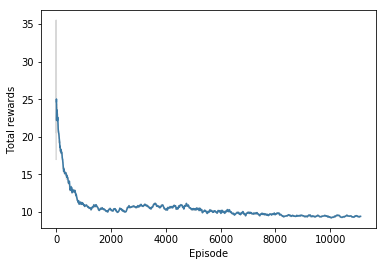

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

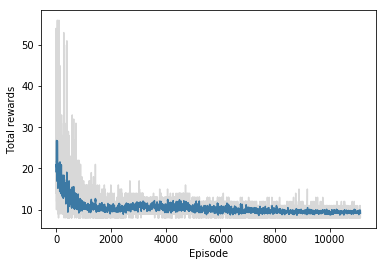

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

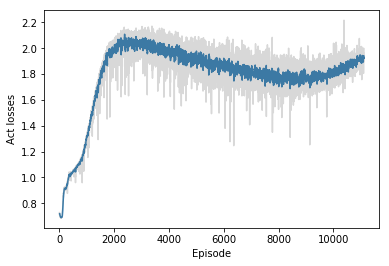

In [20]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

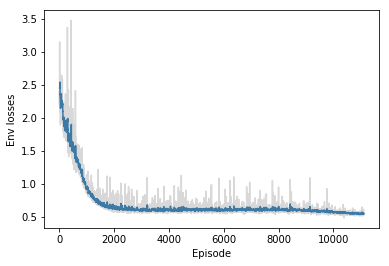

In [21]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
